In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_0_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(553799, 828)
(553799, 1)
validation
(80986, 828)
(80986, 1)
test
(65261, 828)
(65261, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/56 [..............................] - ETA: 1:02 - loss: 0.0289 - STD: 2.0436e-04 - MAE: 0.1525

 2/56 [>.............................] - ETA: 33s - loss: 0.0166 - STD: 2.6422e-04 - MAE: 0.1156 

 5/56 [=>............................] - ETA: 8s - loss: 0.0189 - STD: 2.6950e-04 - MAE: 0.1093 

 6/56 [==>...........................] - ETA: 7s - loss: 0.0189 - STD: 2.7252e-04 - MAE: 0.1082

 7/56 [==>...........................] - ETA: 6s - loss: 0.0185 - STD: 2.8014e-04 - MAE: 0.1058

 8/56 [===>..........................] - ETA: 6s - loss: 0.0179 - STD: 2.9372e-04 - MAE: 0.1031

 9/56 [===>..........................] - ETA: 5s - loss: 0.0171 - STD: 3.1128e-04 - MAE: 0.1004

10/56 [====>.........................] - ETA: 5s - loss: 0.0164 - STD: 3.3188e-04 - MAE: 0.0986

11/56 [====>.........................] - ETA: 5s - loss: 0.0160 - STD: 3.5363e-04 - MAE: 0.0981

12/56 [=====>........................] - ETA: 4s - loss: 0.0158 - STD: 3.7552e-04 - MAE: 0.0984

13/56 [=====>........................] - ETA: 4s - loss: 0.0157 - STD: 3.9750e-04 - MAE: 0.0987

14/56 [======>.......................] - ETA: 4s - loss: 0.0155 - STD: 4.1808e-04 - MAE: 0.0985

15/56 [=======>......................] - ETA: 4s - loss: 0.0152 - STD: 4.3589e-04 - MAE: 0.0977

16/56 [=======>......................] - ETA: 3s - loss: 0.0149 - STD: 4.5131e-04 - MAE: 0.0966

17/56 [========>.....................] - ETA: 3s - loss: 0.0146 - STD: 4.6374e-04 - MAE: 0.0956

18/56 [========>.....................] - ETA: 3s - loss: 0.0144 - STD: 4.7401e-04 - MAE: 0.0946

19/56 [=========>....................] - ETA: 3s - loss: 0.0143 - STD: 4.8322e-04 - MAE: 0.0937

20/56 [=========>....................] - ETA: 3s - loss: 0.0141 - STD: 4.9191e-04 - MAE: 0.0930

21/56 [==========>...................] - ETA: 3s - loss: 0.0140 - STD: 5.0049e-04 - MAE: 0.0923

22/56 [==========>...................] - ETA: 3s - loss: 0.0139 - STD: 5.0996e-04 - MAE: 0.0916

23/56 [===========>..................] - ETA: 2s - loss: 0.0138 - STD: 5.2069e-04 - MAE: 0.0911

24/56 [===========>..................] - ETA: 2s - loss: 0.0137 - STD: 5.3262e-04 - MAE: 0.0905

25/56 [============>.................] - ETA: 2s - loss: 0.0135 - STD: 5.4617e-04 - MAE: 0.0900

26/56 [============>.................] - ETA: 2s - loss: 0.0134 - STD: 5.6140e-04 - MAE: 0.0896

27/56 [=============>................] - ETA: 2s - loss: 0.0133 - STD: 5.7796e-04 - MAE: 0.0893

28/56 [==============>...............] - ETA: 2s - loss: 0.0132 - STD: 5.9553e-04 - MAE: 0.0892

29/56 [==============>...............] - ETA: 2s - loss: 0.0131 - STD: 6.1359e-04 - MAE: 0.0891

30/56 [===============>..............] - ETA: 2s - loss: 0.0131 - STD: 6.3185e-04 - MAE: 0.0890

31/56 [===============>..............] - ETA: 2s - loss: 0.0130 - STD: 6.5020e-04 - MAE: 0.0889

32/56 [================>.............] - ETA: 1s - loss: 0.0129 - STD: 6.6792e-04 - MAE: 0.0887

33/56 [================>.............] - ETA: 1s - loss: 0.0129 - STD: 6.8491e-04 - MAE: 0.0885

34/56 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 7.0126e-04 - MAE: 0.0882

35/56 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 7.1763e-04 - MAE: 0.0880

36/56 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 7.3381e-04 - MAE: 0.0877

37/56 [==================>...........] - ETA: 1s - loss: 0.0126 - STD: 7.5013e-04 - MAE: 0.0874

38/56 [===================>..........] - ETA: 1s - loss: 0.0126 - STD: 7.6717e-04 - MAE: 0.0872

39/56 [===================>..........] - ETA: 1s - loss: 0.0125 - STD: 7.8469e-04 - MAE: 0.0870

40/56 [====================>.........] - ETA: 1s - loss: 0.0125 - STD: 8.0352e-04 - MAE: 0.0867

41/56 [====================>.........] - ETA: 1s - loss: 0.0124 - STD: 8.2412e-04 - MAE: 0.0865

42/56 [=====================>........] - ETA: 1s - loss: 0.0124 - STD: 8.4616e-04 - MAE: 0.0864

43/56 [======================>.......] - ETA: 1s - loss: 0.0123 - STD: 8.7019e-04 - MAE: 0.0862

44/56 [======================>.......] - ETA: 0s - loss: 0.0123 - STD: 8.9579e-04 - MAE: 0.0861

45/56 [=======================>......] - ETA: 0s - loss: 0.0123 - STD: 9.2291e-04 - MAE: 0.0860

46/56 [=======================>......] - ETA: 0s - loss: 0.0122 - STD: 9.5081e-04 - MAE: 0.0859

47/56 [========================>.....] - ETA: 0s - loss: 0.0122 - STD: 9.8019e-04 - MAE: 0.0858

48/56 [========================>.....] - ETA: 0s - loss: 0.0121 - STD: 0.0010 - MAE: 0.0857    

49/56 [=========================>....] - ETA: 0s - loss: 0.0121 - STD: 0.0010 - MAE: 0.0856

50/56 [=========================>....] - ETA: 0s - loss: 0.0121 - STD: 0.0011 - MAE: 0.0855

51/56 [==========================>...] - ETA: 0s - loss: 0.0120 - STD: 0.0011 - MAE: 0.0854

52/56 [==========================>...] - ETA: 0s - loss: 0.0120 - STD: 0.0011 - MAE: 0.0852

53/56 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 0.0012 - MAE: 0.0851

54/56 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 0.0012 - MAE: 0.0850

55/56 [============================>.] - ETA: 0s - loss: 0.0119 - STD: 0.0013 - MAE: 0.0849

56/56 [==============================] - ETA: 0s - loss: 0.0119 - STD: 0.0013 - MAE: 0.0848

56/56 [==============================] - 6s 87ms/step - loss: 0.0119 - STD: 0.0013 - MAE: 0.0848 - val_loss: 0.0115 - val_STD: 0.0036 - val_MAE: 0.0799


Epoch 2/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0105 - STD: 0.0039 - MAE: 0.0793

 2/56 [>.............................] - ETA: 3s - loss: 0.0102 - STD: 0.0040 - MAE: 0.0791

 3/56 [>.............................] - ETA: 3s - loss: 0.0102 - STD: 0.0042 - MAE: 0.0791

 4/56 [=>............................] - ETA: 3s - loss: 0.0102 - STD: 0.0043 - MAE: 0.0792

 5/56 [=>............................] - ETA: 3s - loss: 0.0103 - STD: 0.0045 - MAE: 0.0796

 6/56 [==>...........................] - ETA: 3s - loss: 0.0103 - STD: 0.0046 - MAE: 0.0796

 7/56 [==>...........................] - ETA: 3s - loss: 0.0103 - STD: 0.0048 - MAE: 0.0796

 8/56 [===>..........................] - ETA: 3s - loss: 0.0103 - STD: 0.0050 - MAE: 0.0795

 9/56 [===>..........................] - ETA: 3s - loss: 0.0103 - STD: 0.0051 - MAE: 0.0794

10/56 [====>.........................] - ETA: 3s - loss: 0.0102 - STD: 0.0053 - MAE: 0.0792

11/56 [====>.........................] - ETA: 3s - loss: 0.0102 - STD: 0.0055 - MAE: 0.0789

12/56 [=====>........................] - ETA: 3s - loss: 0.0102 - STD: 0.0057 - MAE: 0.0788

13/56 [=====>........................] - ETA: 3s - loss: 0.0101 - STD: 0.0059 - MAE: 0.0787

14/56 [======>.......................] - ETA: 2s - loss: 0.0101 - STD: 0.0062 - MAE: 0.0787

15/56 [=======>......................] - ETA: 2s - loss: 0.0101 - STD: 0.0064 - MAE: 0.0786

17/56 [========>.....................] - ETA: 2s - loss: 0.0101 - STD: 0.0070 - MAE: 0.0785

18/56 [========>.....................] - ETA: 2s - loss: 0.0101 - STD: 0.0073 - MAE: 0.0785

19/56 [=========>....................] - ETA: 2s - loss: 0.0100 - STD: 0.0077 - MAE: 0.0784

20/56 [=========>....................] - ETA: 2s - loss: 0.0100 - STD: 0.0080 - MAE: 0.0783

21/56 [==========>...................] - ETA: 2s - loss: 0.0100 - STD: 0.0084 - MAE: 0.0782

22/56 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 0.0088 - MAE: 0.0781

23/56 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 0.0092 - MAE: 0.0779

24/56 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 0.0096 - MAE: 0.0778

25/56 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 0.0101 - MAE: 0.0777

26/56 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 0.0105 - MAE: 0.0777

27/56 [=============>................] - ETA: 1s - loss: 0.0098 - STD: 0.0111 - MAE: 0.0775

28/56 [==============>...............] - ETA: 1s - loss: 0.0098 - STD: 0.0116 - MAE: 0.0774

29/56 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.0121 - MAE: 0.0774

30/56 [===============>..............] - ETA: 1s - loss: 0.0097 - STD: 0.0127 - MAE: 0.0773

31/56 [===============>..............] - ETA: 1s - loss: 0.0097 - STD: 0.0133 - MAE: 0.0772

32/56 [================>.............] - ETA: 1s - loss: 0.0097 - STD: 0.0139 - MAE: 0.0770

33/56 [================>.............] - ETA: 1s - loss: 0.0096 - STD: 0.0145 - MAE: 0.0769

34/56 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.0151 - MAE: 0.0768

35/56 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.0157 - MAE: 0.0767

36/56 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.0163 - MAE: 0.0766

37/56 [==================>...........] - ETA: 1s - loss: 0.0095 - STD: 0.0169 - MAE: 0.0765

38/56 [===================>..........] - ETA: 1s - loss: 0.0095 - STD: 0.0176 - MAE: 0.0763

39/56 [===================>..........] - ETA: 1s - loss: 0.0095 - STD: 0.0181 - MAE: 0.0763

40/56 [====================>.........] - ETA: 1s - loss: 0.0095 - STD: 0.0187 - MAE: 0.0762

41/56 [====================>.........] - ETA: 1s - loss: 0.0094 - STD: 0.0193 - MAE: 0.0761

42/56 [=====================>........] - ETA: 0s - loss: 0.0094 - STD: 0.0198 - MAE: 0.0760

43/56 [======================>.......] - ETA: 0s - loss: 0.0094 - STD: 0.0203 - MAE: 0.0759

44/56 [======================>.......] - ETA: 0s - loss: 0.0094 - STD: 0.0208 - MAE: 0.0758

45/56 [=======================>......] - ETA: 0s - loss: 0.0094 - STD: 0.0213 - MAE: 0.0757

46/56 [=======================>......] - ETA: 0s - loss: 0.0093 - STD: 0.0217 - MAE: 0.0755

47/56 [========================>.....] - ETA: 0s - loss: 0.0093 - STD: 0.0221 - MAE: 0.0754

48/56 [========================>.....] - ETA: 0s - loss: 0.0093 - STD: 0.0225 - MAE: 0.0753

49/56 [=========================>....] - ETA: 0s - loss: 0.0093 - STD: 0.0229 - MAE: 0.0752

50/56 [=========================>....] - ETA: 0s - loss: 0.0093 - STD: 0.0233 - MAE: 0.0752

51/56 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 0.0236 - MAE: 0.0751

52/56 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 0.0239 - MAE: 0.0750

53/56 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 0.0242 - MAE: 0.0749

54/56 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 0.0246 - MAE: 0.0749

55/56 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 0.0249 - MAE: 0.0748

56/56 [==============================] - ETA: 0s - loss: 0.0092 - STD: 0.0252 - MAE: 0.0747

56/56 [==============================] - 4s 72ms/step - loss: 0.0092 - STD: 0.0252 - MAE: 0.0747 - val_loss: 0.0090 - val_STD: 0.0389 - val_MAE: 0.0700


Epoch 3/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0081 - STD: 0.0429 - MAE: 0.0691

 2/56 [>.............................] - ETA: 3s - loss: 0.0081 - STD: 0.0430 - MAE: 0.0694

 3/56 [>.............................] - ETA: 3s - loss: 0.0081 - STD: 0.0434 - MAE: 0.0694

 4/56 [=>............................] - ETA: 3s - loss: 0.0081 - STD: 0.0436 - MAE: 0.0693

 5/56 [=>............................] - ETA: 3s - loss: 0.0081 - STD: 0.0438 - MAE: 0.0691

 6/56 [==>...........................] - ETA: 3s - loss: 0.0081 - STD: 0.0441 - MAE: 0.0692

 7/56 [==>...........................] - ETA: 3s - loss: 0.0081 - STD: 0.0443 - MAE: 0.0692

 8/56 [===>..........................] - ETA: 3s - loss: 0.0081 - STD: 0.0445 - MAE: 0.0693

 9/56 [===>..........................] - ETA: 3s - loss: 0.0081 - STD: 0.0447 - MAE: 0.0693

10/56 [====>.........................] - ETA: 3s - loss: 0.0081 - STD: 0.0450 - MAE: 0.0692

11/56 [====>.........................] - ETA: 3s - loss: 0.0081 - STD: 0.0451 - MAE: 0.0692

12/56 [=====>........................] - ETA: 2s - loss: 0.0081 - STD: 0.0452 - MAE: 0.0692

13/56 [=====>........................] - ETA: 2s - loss: 0.0081 - STD: 0.0452 - MAE: 0.0692

14/56 [======>.......................] - ETA: 2s - loss: 0.0081 - STD: 0.0452 - MAE: 0.0692

15/56 [=======>......................] - ETA: 2s - loss: 0.0081 - STD: 0.0453 - MAE: 0.0691

16/56 [=======>......................] - ETA: 2s - loss: 0.0081 - STD: 0.0453 - MAE: 0.0690

17/56 [========>.....................] - ETA: 2s - loss: 0.0081 - STD: 0.0454 - MAE: 0.0690

18/56 [========>.....................] - ETA: 2s - loss: 0.0081 - STD: 0.0454 - MAE: 0.0690

19/56 [=========>....................] - ETA: 2s - loss: 0.0080 - STD: 0.0455 - MAE: 0.0689

20/56 [=========>....................] - ETA: 2s - loss: 0.0080 - STD: 0.0456 - MAE: 0.0688

21/56 [==========>...................] - ETA: 2s - loss: 0.0080 - STD: 0.0457 - MAE: 0.0688

23/56 [===========>..................] - ETA: 2s - loss: 0.0080 - STD: 0.0458 - MAE: 0.0687

24/56 [===========>..................] - ETA: 2s - loss: 0.0080 - STD: 0.0459 - MAE: 0.0686

25/56 [============>.................] - ETA: 2s - loss: 0.0080 - STD: 0.0461 - MAE: 0.0685

26/56 [============>.................] - ETA: 1s - loss: 0.0080 - STD: 0.0462 - MAE: 0.0685

27/56 [=============>................] - ETA: 1s - loss: 0.0080 - STD: 0.0463 - MAE: 0.0684

28/56 [==============>...............] - ETA: 1s - loss: 0.0079 - STD: 0.0464 - MAE: 0.0683

29/56 [==============>...............] - ETA: 1s - loss: 0.0079 - STD: 0.0466 - MAE: 0.0682

30/56 [===============>..............] - ETA: 1s - loss: 0.0079 - STD: 0.0466 - MAE: 0.0681

31/56 [===============>..............] - ETA: 1s - loss: 0.0079 - STD: 0.0467 - MAE: 0.0680

32/56 [================>.............] - ETA: 1s - loss: 0.0078 - STD: 0.0469 - MAE: 0.0679

33/56 [================>.............] - ETA: 1s - loss: 0.0078 - STD: 0.0470 - MAE: 0.0678

34/56 [=================>............] - ETA: 1s - loss: 0.0078 - STD: 0.0471 - MAE: 0.0677

35/56 [=================>............] - ETA: 1s - loss: 0.0078 - STD: 0.0472 - MAE: 0.0676

36/56 [==================>...........] - ETA: 1s - loss: 0.0077 - STD: 0.0474 - MAE: 0.0675

37/56 [==================>...........] - ETA: 1s - loss: 0.0077 - STD: 0.0475 - MAE: 0.0674

38/56 [===================>..........] - ETA: 1s - loss: 0.0077 - STD: 0.0476 - MAE: 0.0672

39/56 [===================>..........] - ETA: 1s - loss: 0.0077 - STD: 0.0479 - MAE: 0.0672

40/56 [====================>.........] - ETA: 1s - loss: 0.0077 - STD: 0.0481 - MAE: 0.0670

41/56 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.0482 - MAE: 0.0669

42/56 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.0486 - MAE: 0.0669

43/56 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.0488 - MAE: 0.0667

44/56 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.0491 - MAE: 0.0666

45/56 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.0495 - MAE: 0.0665

46/56 [=======================>......] - ETA: 0s - loss: 0.0075 - STD: 0.0497 - MAE: 0.0664

47/56 [========================>.....] - ETA: 0s - loss: 0.0075 - STD: 0.0500 - MAE: 0.0662

48/56 [========================>.....] - ETA: 0s - loss: 0.0075 - STD: 0.0503 - MAE: 0.0662

49/56 [=========================>....] - ETA: 0s - loss: 0.0075 - STD: 0.0505 - MAE: 0.0660

50/56 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.0508 - MAE: 0.0659

51/56 [==========================>...] - ETA: 0s - loss: 0.0074 - STD: 0.0511 - MAE: 0.0658

52/56 [==========================>...] - ETA: 0s - loss: 0.0074 - STD: 0.0513 - MAE: 0.0657

53/56 [===========================>..] - ETA: 0s - loss: 0.0074 - STD: 0.0515 - MAE: 0.0655

54/56 [===========================>..] - ETA: 0s - loss: 0.0074 - STD: 0.0517 - MAE: 0.0655

55/56 [============================>.] - ETA: 0s - loss: 0.0073 - STD: 0.0519 - MAE: 0.0654

56/56 [==============================] - ETA: 0s - loss: 0.0073 - STD: 0.0521 - MAE: 0.0652

56/56 [==============================] - 4s 72ms/step - loss: 0.0073 - STD: 0.0521 - MAE: 0.0652 - val_loss: 0.0066 - val_STD: 0.0651 - val_MAE: 0.0617


Epoch 4/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0061 - STD: 0.0652 - MAE: 0.0608

 2/56 [>.............................] - ETA: 3s - loss: 0.0063 - STD: 0.0623 - MAE: 0.0597

 3/56 [>.............................] - ETA: 3s - loss: 0.0062 - STD: 0.0621 - MAE: 0.0594

 4/56 [=>............................] - ETA: 3s - loss: 0.0062 - STD: 0.0632 - MAE: 0.0598

 5/56 [=>............................] - ETA: 3s - loss: 0.0062 - STD: 0.0628 - MAE: 0.0596

 6/56 [==>...........................] - ETA: 3s - loss: 0.0062 - STD: 0.0628 - MAE: 0.0592

 7/56 [==>...........................] - ETA: 3s - loss: 0.0061 - STD: 0.0632 - MAE: 0.0592

 8/56 [===>..........................] - ETA: 3s - loss: 0.0062 - STD: 0.0629 - MAE: 0.0591

 9/56 [===>..........................] - ETA: 3s - loss: 0.0062 - STD: 0.0631 - MAE: 0.0591

10/56 [====>.........................] - ETA: 3s - loss: 0.0062 - STD: 0.0634 - MAE: 0.0592

11/56 [====>.........................] - ETA: 3s - loss: 0.0062 - STD: 0.0629 - MAE: 0.0591

12/56 [=====>........................] - ETA: 2s - loss: 0.0062 - STD: 0.0630 - MAE: 0.0591

13/56 [=====>........................] - ETA: 2s - loss: 0.0062 - STD: 0.0634 - MAE: 0.0591

14/56 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0631 - MAE: 0.0589

15/56 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0631 - MAE: 0.0588

16/56 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0634 - MAE: 0.0590

17/56 [========>.....................] - ETA: 2s - loss: 0.0061 - STD: 0.0632 - MAE: 0.0588

18/56 [========>.....................] - ETA: 2s - loss: 0.0061 - STD: 0.0632 - MAE: 0.0588

19/56 [=========>....................] - ETA: 2s - loss: 0.0061 - STD: 0.0635 - MAE: 0.0590

20/56 [=========>....................] - ETA: 2s - loss: 0.0062 - STD: 0.0632 - MAE: 0.0589

21/56 [==========>...................] - ETA: 2s - loss: 0.0062 - STD: 0.0633 - MAE: 0.0589

22/56 [==========>...................] - ETA: 2s - loss: 0.0062 - STD: 0.0637 - MAE: 0.0590

23/56 [===========>..................] - ETA: 2s - loss: 0.0062 - STD: 0.0634 - MAE: 0.0590

24/56 [===========>..................] - ETA: 2s - loss: 0.0062 - STD: 0.0633 - MAE: 0.0589

25/56 [============>.................] - ETA: 2s - loss: 0.0062 - STD: 0.0638 - MAE: 0.0592

26/56 [============>.................] - ETA: 2s - loss: 0.0062 - STD: 0.0636 - MAE: 0.0591

27/56 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0634 - MAE: 0.0590

28/56 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0637 - MAE: 0.0590

29/56 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0639 - MAE: 0.0590

30/56 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0637 - MAE: 0.0589

31/56 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0637 - MAE: 0.0588

32/56 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.0639 - MAE: 0.0589

33/56 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.0639 - MAE: 0.0589

34/56 [=================>............] - ETA: 1s - loss: 0.0062 - STD: 0.0638 - MAE: 0.0587

35/56 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.0639 - MAE: 0.0587

37/56 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.0640 - MAE: 0.0587

38/56 [===================>..........] - ETA: 1s - loss: 0.0061 - STD: 0.0640 - MAE: 0.0586

39/56 [===================>..........] - ETA: 1s - loss: 0.0061 - STD: 0.0641 - MAE: 0.0586

40/56 [====================>.........] - ETA: 1s - loss: 0.0061 - STD: 0.0642 - MAE: 0.0585

41/56 [====================>.........] - ETA: 1s - loss: 0.0061 - STD: 0.0641 - MAE: 0.0585

42/56 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0641 - MAE: 0.0584

43/56 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0643 - MAE: 0.0584

44/56 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0643 - MAE: 0.0584

45/56 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0643 - MAE: 0.0583

46/56 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0644 - MAE: 0.0583

47/56 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0645 - MAE: 0.0582

48/56 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0645 - MAE: 0.0581

49/56 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0646 - MAE: 0.0581

50/56 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0647 - MAE: 0.0581

51/56 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0647 - MAE: 0.0580

52/56 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0648 - MAE: 0.0580

53/56 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0649 - MAE: 0.0580

54/56 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0649 - MAE: 0.0580

55/56 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0649 - MAE: 0.0579

56/56 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0651 - MAE: 0.0580

56/56 [==============================] - 4s 72ms/step - loss: 0.0060 - STD: 0.0651 - MAE: 0.0580 - val_loss: 0.0059 - val_STD: 0.0649 - val_MAE: 0.0547


Epoch 5/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0057 - STD: 0.0649 - MAE: 0.0547

 2/56 [>.............................] - ETA: 3s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0548

 3/56 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.0677 - MAE: 0.0564

 4/56 [=>............................] - ETA: 3s - loss: 0.0057 - STD: 0.0675 - MAE: 0.0559

 5/56 [=>............................] - ETA: 3s - loss: 0.0057 - STD: 0.0667 - MAE: 0.0557

 6/56 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0678 - MAE: 0.0560

 7/56 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0677 - MAE: 0.0558

 8/56 [===>..........................] - ETA: 3s - loss: 0.0056 - STD: 0.0674 - MAE: 0.0556

 9/56 [===>..........................] - ETA: 3s - loss: 0.0056 - STD: 0.0676 - MAE: 0.0557

10/56 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0677 - MAE: 0.0558

11/56 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0674 - MAE: 0.0557

12/56 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0675 - MAE: 0.0558

13/56 [=====>........................] - ETA: 2s - loss: 0.0057 - STD: 0.0678 - MAE: 0.0558

14/56 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0676 - MAE: 0.0557

15/56 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0677 - MAE: 0.0556

16/56 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0679 - MAE: 0.0556

17/56 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0678 - MAE: 0.0555

18/56 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0678 - MAE: 0.0555

19/56 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0680 - MAE: 0.0555

20/56 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0679 - MAE: 0.0554

21/56 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0679 - MAE: 0.0553

22/56 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0681 - MAE: 0.0554

23/56 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0680 - MAE: 0.0553

24/56 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0680 - MAE: 0.0552

26/56 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0681 - MAE: 0.0554

27/56 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0682 - MAE: 0.0553

28/56 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0685 - MAE: 0.0554

29/56 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0683 - MAE: 0.0554

30/56 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0683 - MAE: 0.0553

31/56 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0556

32/56 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0684 - MAE: 0.0556

33/56 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0682 - MAE: 0.0556

34/56 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0686 - MAE: 0.0559

35/56 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0684 - MAE: 0.0559

36/56 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0681 - MAE: 0.0559

37/56 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0683 - MAE: 0.0560

38/56 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0684 - MAE: 0.0560

39/56 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0681 - MAE: 0.0560

40/56 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0680 - MAE: 0.0560

41/56 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0681 - MAE: 0.0562

42/56 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0681 - MAE: 0.0562

43/56 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0679 - MAE: 0.0561

44/56 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0678 - MAE: 0.0561

45/56 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0679 - MAE: 0.0562

46/56 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0679 - MAE: 0.0561

47/56 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0677 - MAE: 0.0561

48/56 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0677 - MAE: 0.0561

49/56 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0677 - MAE: 0.0561

50/56 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0677 - MAE: 0.0560

51/56 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0677 - MAE: 0.0560

52/56 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0676 - MAE: 0.0560

53/56 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0677 - MAE: 0.0560

54/56 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0678 - MAE: 0.0560

55/56 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0677 - MAE: 0.0559

56/56 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0677 - MAE: 0.0559

56/56 [==============================] - 4s 72ms/step - loss: 0.0057 - STD: 0.0677 - MAE: 0.0559 - val_loss: 0.0055 - val_STD: 0.0720 - val_MAE: 0.0553


Epoch 6/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0052 - STD: 0.0734 - MAE: 0.0552

 2/56 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0707 - MAE: 0.0543

 3/56 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0695 - MAE: 0.0539

 4/56 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0705 - MAE: 0.0540

 5/56 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0710 - MAE: 0.0540

 6/56 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0706 - MAE: 0.0540

 7/56 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0707 - MAE: 0.0540

 8/56 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0711 - MAE: 0.0540

 9/56 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0710 - MAE: 0.0539

10/56 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0710 - MAE: 0.0538

11/56 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0713 - MAE: 0.0539

12/56 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0713 - MAE: 0.0537

13/56 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0712 - MAE: 0.0537

14/56 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0713 - MAE: 0.0537

15/56 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0537

16/56 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0537

17/56 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0536

18/56 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0716 - MAE: 0.0536

19/56 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0716 - MAE: 0.0535

20/56 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0716 - MAE: 0.0535

21/56 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0718 - MAE: 0.0536

22/56 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0718 - MAE: 0.0535

23/56 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0717 - MAE: 0.0535

24/56 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0718 - MAE: 0.0535

25/56 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0719 - MAE: 0.0536

26/56 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0718 - MAE: 0.0535

27/56 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0719 - MAE: 0.0535

28/56 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0719 - MAE: 0.0535

29/56 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0719 - MAE: 0.0534

30/56 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0719 - MAE: 0.0534

31/56 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0719 - MAE: 0.0534

32/56 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0718 - MAE: 0.0534

33/56 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0719 - MAE: 0.0534

34/56 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0719 - MAE: 0.0534

35/56 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0719 - MAE: 0.0534

36/56 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0720 - MAE: 0.0533

37/56 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0719 - MAE: 0.0533

38/56 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0720 - MAE: 0.0533

39/56 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0720 - MAE: 0.0533

40/56 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0721 - MAE: 0.0533

41/56 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0721 - MAE: 0.0533

42/56 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0721 - MAE: 0.0533

43/56 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0721 - MAE: 0.0532

44/56 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0722 - MAE: 0.0533

45/56 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0722 - MAE: 0.0532

46/56 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0722 - MAE: 0.0532

47/56 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0532

48/56 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0722 - MAE: 0.0532

49/56 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0722 - MAE: 0.0533

50/56 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0533

52/56 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0532

53/56 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0532

54/56 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0532

55/56 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0532

56/56 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0532

56/56 [==============================] - 4s 72ms/step - loss: 0.0052 - STD: 0.0723 - MAE: 0.0532 - val_loss: 0.0051 - val_STD: 0.0719 - val_MAE: 0.0513


Epoch 7/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0729 - MAE: 0.0519

 2/56 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0747 - MAE: 0.0528

 3/56 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0726 - MAE: 0.0523

 5/56 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0524

 6/56 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0730 - MAE: 0.0522

 7/56 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0526

 8/56 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.0731 - MAE: 0.0525

 9/56 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0526

10/56 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0526

11/56 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0526

12/56 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0526

13/56 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0526

14/56 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0526

15/56 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0525

16/56 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0525

17/56 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0525

18/56 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0525

19/56 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0525

20/56 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0525

21/56 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0525

22/56 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0524

23/56 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0524

24/56 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0524

25/56 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0524

26/56 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0524

27/56 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0523

28/56 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0523

29/56 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0523

30/56 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0524

31/56 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0524

32/56 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0737 - MAE: 0.0525

33/56 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0525

34/56 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0525

35/56 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0525

36/56 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0525

37/56 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0525

38/56 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0524

39/56 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0525

40/56 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0525

41/56 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0525

42/56 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0525

43/56 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0525

44/56 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0526

45/56 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0732 - MAE: 0.0526

46/56 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0526

47/56 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0527

48/56 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0731 - MAE: 0.0528

49/56 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0731 - MAE: 0.0528

50/56 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0529

51/56 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0729 - MAE: 0.0530

52/56 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0729 - MAE: 0.0530

53/56 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0731 - MAE: 0.0534

54/56 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0727 - MAE: 0.0536

55/56 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0722 - MAE: 0.0538

56/56 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0724 - MAE: 0.0541

56/56 [==============================] - 4s 71ms/step - loss: 0.0054 - STD: 0.0724 - MAE: 0.0541 - val_loss: 0.0054 - val_STD: 0.0711 - val_MAE: 0.0563


Epoch 8/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0052 - STD: 0.0726 - MAE: 0.0569

 2/56 [>.............................] - ETA: 3s - loss: 0.0059 - STD: 0.0618 - MAE: 0.0569

 3/56 [>.............................] - ETA: 3s - loss: 0.0059 - STD: 0.0593 - MAE: 0.0560

 4/56 [=>............................] - ETA: 3s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0573

 5/56 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0579

 6/56 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0624 - MAE: 0.0573

 7/56 [==>...........................] - ETA: 3s - loss: 0.0059 - STD: 0.0610 - MAE: 0.0570

 8/56 [===>..........................] - ETA: 3s - loss: 0.0058 - STD: 0.0613 - MAE: 0.0569

 9/56 [===>..........................] - ETA: 3s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0578

10/56 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0622 - MAE: 0.0575

11/56 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0615 - MAE: 0.0572

12/56 [=====>........................] - ETA: 3s - loss: 0.0058 - STD: 0.0613 - MAE: 0.0569

13/56 [=====>........................] - ETA: 2s - loss: 0.0058 - STD: 0.0620 - MAE: 0.0570

14/56 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0625 - MAE: 0.0571

16/56 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0622 - MAE: 0.0566

17/56 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0626 - MAE: 0.0564

18/56 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0632 - MAE: 0.0565

19/56 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0634 - MAE: 0.0563

20/56 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0634 - MAE: 0.0562

21/56 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0637 - MAE: 0.0560

22/56 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0641 - MAE: 0.0559

23/56 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0645 - MAE: 0.0558

24/56 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0646 - MAE: 0.0556

25/56 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0649 - MAE: 0.0554

26/56 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0652 - MAE: 0.0554

27/56 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0655 - MAE: 0.0552

28/56 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0657 - MAE: 0.0551

29/56 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0550

30/56 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0550

31/56 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0549

32/56 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0548

33/56 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0670 - MAE: 0.0547

34/56 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0673 - MAE: 0.0547

35/56 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0546

36/56 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0676 - MAE: 0.0544

37/56 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0679 - MAE: 0.0544

38/56 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0681 - MAE: 0.0544

39/56 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0543

40/56 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0684 - MAE: 0.0542

41/56 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0686 - MAE: 0.0542

42/56 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0688 - MAE: 0.0541

43/56 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0689 - MAE: 0.0541

44/56 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0690 - MAE: 0.0540

45/56 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0691 - MAE: 0.0539

46/56 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0692 - MAE: 0.0539

47/56 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0694 - MAE: 0.0539

48/56 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0694 - MAE: 0.0538

49/56 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0695 - MAE: 0.0537

50/56 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0696 - MAE: 0.0537

51/56 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0697 - MAE: 0.0537

52/56 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0698 - MAE: 0.0536

53/56 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0699 - MAE: 0.0536

54/56 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0700 - MAE: 0.0535

55/56 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0701 - MAE: 0.0535

56/56 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0701 - MAE: 0.0535

56/56 [==============================] - 4s 73ms/step - loss: 0.0052 - STD: 0.0701 - MAE: 0.0535 - val_loss: 0.0049 - val_STD: 0.0716 - val_MAE: 0.0502


Epoch 9/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0729 - MAE: 0.0507

 2/56 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0742 - MAE: 0.0508

 3/56 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0740 - MAE: 0.0511

 4/56 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0740 - MAE: 0.0511

 5/56 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0741 - MAE: 0.0512

 6/56 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0742 - MAE: 0.0511

 7/56 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0740 - MAE: 0.0510

 8/56 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0741 - MAE: 0.0511

 9/56 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0742 - MAE: 0.0511

10/56 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0742 - MAE: 0.0511

11/56 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0743 - MAE: 0.0510

12/56 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0745 - MAE: 0.0511

13/56 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0512

14/56 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0746 - MAE: 0.0512

15/56 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0512

16/56 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0512

17/56 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0511

18/56 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0748 - MAE: 0.0512

19/56 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0512

20/56 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0512

21/56 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0512

22/56 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0512

23/56 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0512

24/56 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0512

26/56 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0513

27/56 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0512

28/56 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0513

29/56 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0513

30/56 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

31/56 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

32/56 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

33/56 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

34/56 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

35/56 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

36/56 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0512

37/56 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0512

38/56 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0512

39/56 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0512

40/56 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0512

41/56 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0511

42/56 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0512

43/56 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0511

44/56 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0511

45/56 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0511

46/56 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0511

47/56 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0511

48/56 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0511

49/56 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0511

50/56 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0511

51/56 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0511

52/56 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0511

53/56 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0511

54/56 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0511

55/56 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0511

56/56 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0512

56/56 [==============================] - 4s 71ms/step - loss: 0.0048 - STD: 0.0756 - MAE: 0.0512 - val_loss: 0.0058 - val_STD: 0.0630 - val_MAE: 0.0526


Epoch 10/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0523

 3/56 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0741 - MAE: 0.0531

 4/56 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0712 - MAE: 0.0533

 5/56 [=>............................] - ETA: 2s - loss: 0.0053 - STD: 0.0722 - MAE: 0.0528

 6/56 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0740 - MAE: 0.0537

 7/56 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0716 - MAE: 0.0543

 8/56 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.0715 - MAE: 0.0539

 9/56 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.0734 - MAE: 0.0557

10/56 [====>.........................] - ETA: 2s - loss: 0.0060 - STD: 0.0710 - MAE: 0.0566

11/56 [====>.........................] - ETA: 2s - loss: 0.0061 - STD: 0.0692 - MAE: 0.0570

12/56 [=====>........................] - ETA: 2s - loss: 0.0062 - STD: 0.0705 - MAE: 0.0579

13/56 [=====>........................] - ETA: 2s - loss: 0.0061 - STD: 0.0706 - MAE: 0.0575

14/56 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0574

15/56 [=======>......................] - ETA: 2s - loss: 0.0060 - STD: 0.0689 - MAE: 0.0570

16/56 [=======>......................] - ETA: 2s - loss: 0.0060 - STD: 0.0694 - MAE: 0.0573

17/56 [========>.....................] - ETA: 2s - loss: 0.0060 - STD: 0.0692 - MAE: 0.0571

18/56 [========>.....................] - ETA: 2s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0569

19/56 [=========>....................] - ETA: 2s - loss: 0.0059 - STD: 0.0679 - MAE: 0.0566

20/56 [=========>....................] - ETA: 2s - loss: 0.0059 - STD: 0.0681 - MAE: 0.0567

21/56 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0681 - MAE: 0.0567

22/56 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0677 - MAE: 0.0565

23/56 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0675 - MAE: 0.0563

24/56 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0676 - MAE: 0.0562

25/56 [============>.................] - ETA: 2s - loss: 0.0057 - STD: 0.0677 - MAE: 0.0561

26/56 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0676 - MAE: 0.0560

27/56 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0676 - MAE: 0.0558

28/56 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0677 - MAE: 0.0557

29/56 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0680 - MAE: 0.0556

30/56 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0681 - MAE: 0.0555

31/56 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0681 - MAE: 0.0554

32/56 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0683 - MAE: 0.0553

33/56 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0686 - MAE: 0.0552

34/56 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0687 - MAE: 0.0551

35/56 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0688 - MAE: 0.0550

36/56 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0690 - MAE: 0.0549

37/56 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0693 - MAE: 0.0549

38/56 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0694 - MAE: 0.0547

39/56 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0694 - MAE: 0.0546

40/56 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0697 - MAE: 0.0546

41/56 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0699 - MAE: 0.0545

42/56 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0700 - MAE: 0.0545

43/56 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0701 - MAE: 0.0544

44/56 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0703 - MAE: 0.0543

45/56 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0704 - MAE: 0.0542

46/56 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0705 - MAE: 0.0542

47/56 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0707 - MAE: 0.0541

48/56 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0708 - MAE: 0.0541

49/56 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0708 - MAE: 0.0540

50/56 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0710 - MAE: 0.0539

51/56 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0711 - MAE: 0.0539

52/56 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0711 - MAE: 0.0538

53/56 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0712 - MAE: 0.0538

54/56 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0713 - MAE: 0.0537

55/56 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0537

56/56 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0714 - MAE: 0.0536

56/56 [==============================] - 4s 71ms/step - loss: 0.0052 - STD: 0.0714 - MAE: 0.0536 - val_loss: 0.0048 - val_STD: 0.0735 - val_MAE: 0.0498


Epoch 11/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0756 - MAE: 0.0508

 2/56 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0512

 3/56 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0754 - MAE: 0.0508

 4/56 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0744 - MAE: 0.0508

 5/56 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0747 - MAE: 0.0510

 6/56 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0751 - MAE: 0.0511

 7/56 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0747 - MAE: 0.0510

 8/56 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0746 - MAE: 0.0511

 9/56 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0749 - MAE: 0.0511

10/56 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0748 - MAE: 0.0511

11/56 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0747 - MAE: 0.0510

12/56 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0749 - MAE: 0.0510

13/56 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0749 - MAE: 0.0510

14/56 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0748 - MAE: 0.0510

15/56 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0749 - MAE: 0.0510

16/56 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0750 - MAE: 0.0510

17/56 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0510

18/56 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0751 - MAE: 0.0510

19/56 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0753 - MAE: 0.0510

20/56 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0753 - MAE: 0.0510

21/56 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0753 - MAE: 0.0510

22/56 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0510

23/56 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0509

24/56 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0509

25/56 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0509

26/56 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0509

27/56 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0508

29/56 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0508

30/56 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0508

31/56 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0508

32/56 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0508

33/56 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0507

34/56 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0507

35/56 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0507

36/56 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0507

37/56 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0507

38/56 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0507

39/56 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0507

40/56 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0507

41/56 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0507

42/56 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0507

43/56 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0507

44/56 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0507

45/56 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0507

46/56 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0507

47/56 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0507

48/56 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0506

49/56 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0506

50/56 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0507

51/56 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0506

52/56 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0506

53/56 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0507

54/56 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0507

55/56 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0506

56/56 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0506

56/56 [==============================] - 4s 72ms/step - loss: 0.0047 - STD: 0.0761 - MAE: 0.0506 - val_loss: 0.0050 - val_STD: 0.0688 - val_MAE: 0.0495


Epoch 12/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0703 - MAE: 0.0498

 2/56 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0743 - MAE: 0.0505

 3/56 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0765 - MAE: 0.0509

 4/56 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0509

 5/56 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0508

 6/56 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0762 - MAE: 0.0508

 7/56 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0507

 8/56 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0507

10/56 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0507

11/56 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0507

12/56 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0508

13/56 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0507

14/56 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0507

15/56 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0509

16/56 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0510

17/56 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0509

18/56 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0760 - MAE: 0.0511

19/56 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0754 - MAE: 0.0513

20/56 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0512

21/56 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0759 - MAE: 0.0516

22/56 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0752 - MAE: 0.0518

23/56 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0750 - MAE: 0.0517

24/56 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0757 - MAE: 0.0525

25/56 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0748 - MAE: 0.0527

26/56 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0741 - MAE: 0.0529

27/56 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0535

28/56 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0743 - MAE: 0.0533

29/56 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0737 - MAE: 0.0534

30/56 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0735 - MAE: 0.0533

31/56 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0737 - MAE: 0.0537

32/56 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0733 - MAE: 0.0536

33/56 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0728 - MAE: 0.0536

34/56 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0726 - MAE: 0.0535

35/56 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0727 - MAE: 0.0537

36/56 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0725 - MAE: 0.0537

37/56 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0722 - MAE: 0.0536

38/56 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0720 - MAE: 0.0535

39/56 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0721 - MAE: 0.0536

40/56 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0721 - MAE: 0.0536

41/56 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0719 - MAE: 0.0535

42/56 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0718 - MAE: 0.0535

43/56 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0719 - MAE: 0.0535

44/56 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0720 - MAE: 0.0535

45/56 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0719 - MAE: 0.0534

46/56 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0718 - MAE: 0.0533

47/56 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0720 - MAE: 0.0533

48/56 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0721 - MAE: 0.0533

49/56 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0720 - MAE: 0.0532

50/56 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0720 - MAE: 0.0532

51/56 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0721 - MAE: 0.0532

52/56 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0722 - MAE: 0.0531

53/56 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0721 - MAE: 0.0531

54/56 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0722 - MAE: 0.0530

55/56 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0723 - MAE: 0.0530

56/56 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0724 - MAE: 0.0530

56/56 [==============================] - 4s 71ms/step - loss: 0.0051 - STD: 0.0724 - MAE: 0.0530 - val_loss: 0.0050 - val_STD: 0.0685 - val_MAE: 0.0496


Epoch 13/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0716 - MAE: 0.0508

 2/56 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0736 - MAE: 0.0504

 3/56 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0759 - MAE: 0.0515

 4/56 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0757 - MAE: 0.0513

 5/56 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0511

 6/56 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0510

 7/56 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0757 - MAE: 0.0511

 8/56 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0510

 9/56 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0509

10/56 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0509

11/56 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0509

12/56 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0508

13/56 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0508

14/56 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0508

15/56 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0507

16/56 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0753 - MAE: 0.0507

17/56 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0753 - MAE: 0.0507

18/56 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0507

19/56 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0506

20/56 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0753 - MAE: 0.0507

21/56 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0506

22/56 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0506

23/56 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0506

24/56 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0753 - MAE: 0.0506

25/56 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0506

26/56 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0505

27/56 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0505

28/56 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0505

29/56 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0505

30/56 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0504

31/56 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0504

32/56 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0504

33/56 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0504

34/56 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0503

35/56 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0503

36/56 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0503

37/56 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0503

38/56 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0503

39/56 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0760 - MAE: 0.0502

40/56 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0760 - MAE: 0.0502

41/56 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0502

42/56 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0502

43/56 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0502

44/56 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0502

45/56 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0502

46/56 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0502

47/56 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0502

48/56 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0502

49/56 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0502

50/56 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0502

51/56 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0502

53/56 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0502

54/56 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0502

55/56 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0502

56/56 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0501

56/56 [==============================] - 4s 71ms/step - loss: 0.0046 - STD: 0.0764 - MAE: 0.0501 - val_loss: 0.0045 - val_STD: 0.0765 - val_MAE: 0.0485


Epoch 14/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0505

 2/56 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0775 - MAE: 0.0502

 3/56 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0499

 4/56 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0776 - MAE: 0.0501

 5/56 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0501

 6/56 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0501

 7/56 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0501

 8/56 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0499

 9/56 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0498

10/56 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0500

11/56 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0500

12/56 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0500

13/56 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0500

14/56 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0499

15/56 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0499

16/56 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0775 - MAE: 0.0500

17/56 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0500

18/56 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0500

19/56 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0775 - MAE: 0.0500

20/56 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0500

21/56 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0501

22/56 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0501

23/56 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0501

24/56 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0502

25/56 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0502

26/56 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0501

27/56 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0501

28/56 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0501

29/56 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0501

30/56 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0500

31/56 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0501

32/56 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0500

33/56 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0500

34/56 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0501

35/56 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0500

36/56 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0501

37/56 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0501

38/56 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0501

40/56 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0501

41/56 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0501

42/56 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0501

43/56 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0501

44/56 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0501

45/56 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0501

46/56 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0501

47/56 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0501

48/56 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0501

49/56 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0501

50/56 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0501

51/56 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0501

52/56 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0501

53/56 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0500

54/56 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0500

55/56 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0500

56/56 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0500

56/56 [==============================] - 4s 71ms/step - loss: 0.0046 - STD: 0.0769 - MAE: 0.0500 - val_loss: 0.0045 - val_STD: 0.0756 - val_MAE: 0.0478


Epoch 15/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0782 - MAE: 0.0495

 2/56 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0783 - MAE: 0.0496

 3/56 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0781 - MAE: 0.0495

 4/56 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0783 - MAE: 0.0495

 5/56 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0783 - MAE: 0.0494

 6/56 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0780 - MAE: 0.0494

 7/56 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0781 - MAE: 0.0493

 8/56 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0782 - MAE: 0.0494

 9/56 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0494

10/56 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0779 - MAE: 0.0494

11/56 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0495

12/56 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0494

13/56 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0494

14/56 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0494

15/56 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0493

16/56 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0494

17/56 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0494

18/56 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0494

19/56 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0494

20/56 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0494

21/56 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0494

22/56 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0494

23/56 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0494

24/56 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0494

25/56 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0494

26/56 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0494

27/56 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0494

28/56 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0494

29/56 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0494

30/56 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0494

31/56 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0494

32/56 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0494

33/56 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0779 - MAE: 0.0495

34/56 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0495

35/56 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0495

36/56 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0496

37/56 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0496

38/56 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0497

39/56 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0775 - MAE: 0.0497

40/56 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0496

41/56 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0776 - MAE: 0.0497

42/56 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0497

43/56 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0775 - MAE: 0.0497

44/56 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0776 - MAE: 0.0498

45/56 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0498

46/56 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0499

47/56 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0775 - MAE: 0.0500

48/56 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0501

49/56 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0501

50/56 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0774 - MAE: 0.0505

52/56 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0762 - MAE: 0.0512

53/56 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0764 - MAE: 0.0514

54/56 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0764 - MAE: 0.0515

55/56 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0759 - MAE: 0.0516

56/56 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0755 - MAE: 0.0517

56/56 [==============================] - 4s 72ms/step - loss: 0.0049 - STD: 0.0755 - MAE: 0.0517 - val_loss: 0.0056 - val_STD: 0.0730 - val_MAE: 0.0589


Epoch 16/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0055 - STD: 0.0750 - MAE: 0.0598

 2/56 [>.............................] - ETA: 3s - loss: 0.0057 - STD: 0.0746 - MAE: 0.0603

 3/56 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0685 - MAE: 0.0577

 4/56 [=>............................] - ETA: 3s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0568

 5/56 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0645 - MAE: 0.0560

 6/56 [==>...........................] - ETA: 3s - loss: 0.0056 - STD: 0.0663 - MAE: 0.0572

 7/56 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0661 - MAE: 0.0565

 8/56 [===>..........................] - ETA: 3s - loss: 0.0055 - STD: 0.0648 - MAE: 0.0561

 9/56 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0556

10/56 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0653 - MAE: 0.0556

11/56 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0660 - MAE: 0.0556

12/56 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0553

13/56 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0551

14/56 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0548

15/56 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0664 - MAE: 0.0549

16/56 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0547

17/56 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0665 - MAE: 0.0545

18/56 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0543

19/56 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0542

20/56 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0541

21/56 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0539

22/56 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0537

23/56 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0683 - MAE: 0.0537

24/56 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0688 - MAE: 0.0536

25/56 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0690 - MAE: 0.0534

26/56 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0691 - MAE: 0.0533

27/56 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0694 - MAE: 0.0532

28/56 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0532

29/56 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0700 - MAE: 0.0531

30/56 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0700 - MAE: 0.0530

31/56 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0529

32/56 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0528

33/56 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0706 - MAE: 0.0527

34/56 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0527

35/56 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0709 - MAE: 0.0526

36/56 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0711 - MAE: 0.0525

37/56 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0712 - MAE: 0.0524

38/56 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0712 - MAE: 0.0523

39/56 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0714 - MAE: 0.0523

40/56 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0522

41/56 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0521

42/56 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0521

43/56 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0521

44/56 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0719 - MAE: 0.0520

45/56 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0719 - MAE: 0.0520

46/56 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0720 - MAE: 0.0519

47/56 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0721 - MAE: 0.0519

49/56 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0722 - MAE: 0.0518

50/56 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0723 - MAE: 0.0517

51/56 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0725 - MAE: 0.0517

52/56 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0725 - MAE: 0.0516

53/56 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0726 - MAE: 0.0516

54/56 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0727 - MAE: 0.0515

55/56 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0729 - MAE: 0.0515

56/56 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0729 - MAE: 0.0514

56/56 [==============================] - 4s 70ms/step - loss: 0.0048 - STD: 0.0729 - MAE: 0.0514 - val_loss: 0.0044 - val_STD: 0.0774 - val_MAE: 0.0475


Epoch 17/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0792 - MAE: 0.0497

 2/56 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0495

 3/56 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0784 - MAE: 0.0495

 4/56 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0782 - MAE: 0.0494

 5/56 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0785 - MAE: 0.0495

 6/56 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0784 - MAE: 0.0495

 7/56 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0783 - MAE: 0.0495

 8/56 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0786 - MAE: 0.0495

 9/56 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0787 - MAE: 0.0493

10/56 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0785 - MAE: 0.0492

11/56 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0786 - MAE: 0.0492

12/56 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0787 - MAE: 0.0492

13/56 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0785 - MAE: 0.0491

14/56 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0786 - MAE: 0.0491

15/56 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0785 - MAE: 0.0491

16/56 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0785 - MAE: 0.0491

17/56 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0784 - MAE: 0.0490

18/56 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0784 - MAE: 0.0490

19/56 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0783 - MAE: 0.0491

20/56 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0782 - MAE: 0.0490

21/56 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0781 - MAE: 0.0490

22/56 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0782 - MAE: 0.0491

24/56 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0781 - MAE: 0.0491

25/56 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0781 - MAE: 0.0491

26/56 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0781 - MAE: 0.0491

27/56 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0781 - MAE: 0.0491

28/56 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0491

29/56 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0491

30/56 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0491

31/56 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0491

32/56 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0491

33/56 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0782 - MAE: 0.0491

34/56 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0783 - MAE: 0.0491

35/56 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0783 - MAE: 0.0491

36/56 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0783 - MAE: 0.0491

37/56 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0491

38/56 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0491

39/56 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

40/56 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

41/56 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

42/56 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

43/56 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

44/56 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

45/56 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

46/56 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0490

47/56 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

48/56 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0490

49/56 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

50/56 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

51/56 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0490

52/56 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

53/56 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

54/56 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

55/56 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

56/56 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

56/56 [==============================] - 4s 72ms/step - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490 - val_loss: 0.0043 - val_STD: 0.0768 - val_MAE: 0.0468


Epoch 18/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0789 - MAE: 0.0489

 2/56 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0486

 3/56 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0789 - MAE: 0.0486

 4/56 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0486

 5/56 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0486

 6/56 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

 7/56 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0487

 8/56 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0486

 9/56 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0485

10/56 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0790 - MAE: 0.0487

11/56 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0789 - MAE: 0.0487

12/56 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0486

13/56 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0789 - MAE: 0.0487

14/56 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0488

15/56 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0488

16/56 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0790 - MAE: 0.0488

17/56 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0488

18/56 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0789 - MAE: 0.0489

19/56 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0790 - MAE: 0.0489

20/56 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0488

21/56 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0488

22/56 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0488

23/56 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0488

24/56 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

25/56 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

26/56 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

27/56 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

28/56 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

29/56 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

30/56 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0489

31/56 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

32/56 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0489

33/56 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0489

34/56 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

35/56 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

36/56 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0488

37/56 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0488

38/56 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0488

39/56 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0488

40/56 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

41/56 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

42/56 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

44/56 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0488

45/56 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0488

46/56 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

47/56 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0488

48/56 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0488

49/56 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0488

50/56 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0488

51/56 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0488

52/56 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0488

53/56 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0488

54/56 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0488

55/56 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0488

56/56 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0488

56/56 [==============================] - 4s 72ms/step - loss: 0.0044 - STD: 0.0785 - MAE: 0.0488 - val_loss: 0.0043 - val_STD: 0.0766 - val_MAE: 0.0463


Epoch 19/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0799 - MAE: 0.0485

 2/56 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0796 - MAE: 0.0483

 3/56 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0797 - MAE: 0.0482

 4/56 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0795 - MAE: 0.0483

 5/56 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0793 - MAE: 0.0481

 6/56 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0482

 7/56 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0481

 8/56 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0481

 9/56 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0481

10/56 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0480

11/56 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0480

12/56 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0481

14/56 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0481

15/56 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0481

16/56 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0481

17/56 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0482

18/56 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

19/56 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0482

20/56 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0482

21/56 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0484

22/56 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0485

23/56 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0486

24/56 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0486

25/56 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0486

26/56 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0487

27/56 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0487

28/56 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0487

29/56 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0487

30/56 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0487

31/56 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0487

32/56 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0487

33/56 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0486

34/56 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0487

35/56 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0487

36/56 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0487

37/56 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0487

38/56 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0487

39/56 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0487

40/56 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0487

41/56 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0487

42/56 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0488

43/56 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0488

44/56 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0487

45/56 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0488

46/56 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0488

47/56 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0488

48/56 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0488

49/56 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0488

50/56 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0488

51/56 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0488

52/56 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0488

53/56 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0488

54/56 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0488

55/56 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0488

56/56 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0488

56/56 [==============================] - 4s 71ms/step - loss: 0.0044 - STD: 0.0784 - MAE: 0.0488 - val_loss: 0.0043 - val_STD: 0.0804 - val_MAE: 0.0475


Epoch 20/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0813 - MAE: 0.0491

 2/56 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0484

 3/56 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0789 - MAE: 0.0487

 4/56 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0798 - MAE: 0.0489

 5/56 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0489

 6/56 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0794 - MAE: 0.0494

 7/56 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0786 - MAE: 0.0493

 8/56 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0788 - MAE: 0.0492

 9/56 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0790 - MAE: 0.0491

10/56 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0490

11/56 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0791 - MAE: 0.0491

12/56 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0490

13/56 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0789 - MAE: 0.0491

14/56 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0790 - MAE: 0.0490

15/56 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0489

16/56 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0792 - MAE: 0.0490

17/56 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0787 - MAE: 0.0491

18/56 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0789 - MAE: 0.0491

19/56 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0787 - MAE: 0.0491

20/56 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0490

21/56 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0490

22/56 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0490

23/56 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

24/56 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

25/56 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

26/56 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

27/56 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0488

28/56 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0488

29/56 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0488

30/56 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0488

31/56 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0487

32/56 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0489

33/56 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0489

34/56 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0490

35/56 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

36/56 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0489

37/56 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0489

38/56 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0489

39/56 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0489

40/56 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

41/56 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0488

42/56 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0488

43/56 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0488

44/56 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0487

45/56 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0487

46/56 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0487

47/56 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0487

48/56 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0487

49/56 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0487

51/56 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0487

52/56 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0487

53/56 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0487

54/56 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0487

55/56 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0487

56/56 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0486

56/56 [==============================] - 4s 71ms/step - loss: 0.0044 - STD: 0.0785 - MAE: 0.0486 - val_loss: 0.0042 - val_STD: 0.0780 - val_MAE: 0.0459


Epoch 21/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0811 - MAE: 0.0478

 2/56 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0803 - MAE: 0.0481

 3/56 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0806 - MAE: 0.0480

 4/56 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0804 - MAE: 0.0479

 5/56 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0800 - MAE: 0.0479

 6/56 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0799 - MAE: 0.0479

 7/56 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0802 - MAE: 0.0480

 8/56 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0795 - MAE: 0.0480

 9/56 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0802 - MAE: 0.0483

10/56 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0792 - MAE: 0.0484

12/56 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0793 - MAE: 0.0485

13/56 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0794 - MAE: 0.0485

14/56 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0793 - MAE: 0.0485

15/56 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0485

16/56 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0485

17/56 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0484

18/56 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0484

19/56 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0485

20/56 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0484

21/56 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0484

22/56 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0484

23/56 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0484

24/56 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0484

25/56 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

26/56 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

27/56 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

28/56 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

29/56 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0793 - MAE: 0.0484

30/56 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0484

31/56 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0792 - MAE: 0.0485

32/56 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0790 - MAE: 0.0486

33/56 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0791 - MAE: 0.0486

34/56 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0790 - MAE: 0.0486

35/56 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0790 - MAE: 0.0485

36/56 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0791 - MAE: 0.0486

37/56 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0789 - MAE: 0.0485

38/56 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0790 - MAE: 0.0486

39/56 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0789 - MAE: 0.0485

40/56 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0485

41/56 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0790 - MAE: 0.0486

42/56 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0485

43/56 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0486

44/56 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0486

45/56 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0486

46/56 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0486

47/56 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0486

48/56 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0486

49/56 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0487

50/56 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0487

51/56 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0487

52/56 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0487

53/56 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0488

54/56 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0488

55/56 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0489

56/56 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

56/56 [==============================] - 4s 72ms/step - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489 - val_loss: 0.0044 - val_STD: 0.0803 - val_MAE: 0.0490


Epoch 22/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0818 - MAE: 0.0508

 2/56 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0795 - MAE: 0.0493

 3/56 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0768 - MAE: 0.0489

 4/56 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0497

 5/56 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0776 - MAE: 0.0493

 6/56 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0767 - MAE: 0.0490

 7/56 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0774 - MAE: 0.0492

 8/56 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0769 - MAE: 0.0491

 9/56 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0771 - MAE: 0.0490

10/56 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0774 - MAE: 0.0491

11/56 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0770 - MAE: 0.0489

12/56 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0772 - MAE: 0.0488

13/56 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0774 - MAE: 0.0488

14/56 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0773 - MAE: 0.0487

15/56 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0774 - MAE: 0.0487

16/56 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0775 - MAE: 0.0486

17/56 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0775 - MAE: 0.0485

18/56 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0776 - MAE: 0.0485

19/56 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0777 - MAE: 0.0485

20/56 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0777 - MAE: 0.0484

22/56 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0779 - MAE: 0.0483

23/56 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0781 - MAE: 0.0483

24/56 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0780 - MAE: 0.0483

25/56 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0780 - MAE: 0.0483

26/56 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0781 - MAE: 0.0482

27/56 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0781 - MAE: 0.0482

28/56 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0781 - MAE: 0.0482

29/56 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0481

30/56 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0481

31/56 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0481

32/56 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0481

33/56 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0482

34/56 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0482

35/56 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0481

36/56 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0481

37/56 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0481

38/56 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0482

39/56 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0482

40/56 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0482

41/56 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0482

42/56 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0481

43/56 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0482

44/56 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0482

45/56 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0482

46/56 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0482

47/56 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0482

48/56 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0482

49/56 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0482

50/56 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0482

51/56 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0482

52/56 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0482

53/56 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0482

54/56 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0482

55/56 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0482

56/56 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0482

56/56 [==============================] - 4s 72ms/step - loss: 0.0043 - STD: 0.0787 - MAE: 0.0482 - val_loss: 0.0045 - val_STD: 0.0839 - val_MAE: 0.0490


Epoch 23/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0848 - MAE: 0.0510

 2/56 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0791 - MAE: 0.0494

 3/56 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0492

 4/56 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0487

 5/56 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0792 - MAE: 0.0484

 6/56 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0798 - MAE: 0.0487

 7/56 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0791 - MAE: 0.0485

 8/56 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0485

 9/56 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0484

10/56 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

11/56 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0482

12/56 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0482

13/56 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0793 - MAE: 0.0482

14/56 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0481

15/56 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0793 - MAE: 0.0481

16/56 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0795 - MAE: 0.0481

17/56 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0793 - MAE: 0.0480

18/56 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0795 - MAE: 0.0482

19/56 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0481

20/56 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0793 - MAE: 0.0481

21/56 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0794 - MAE: 0.0482

22/56 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0481

23/56 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0481

24/56 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0794 - MAE: 0.0481

25/56 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0482

26/56 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0793 - MAE: 0.0483

27/56 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

28/56 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

29/56 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0482

30/56 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0482

31/56 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0483

32/56 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

33/56 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

34/56 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

35/56 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

36/56 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0484

37/56 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0484

38/56 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

40/56 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

41/56 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

42/56 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

43/56 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0482

44/56 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0482

45/56 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0482

46/56 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0482

47/56 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0482

48/56 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0482

49/56 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0481

50/56 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0481

51/56 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0481

52/56 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0481

53/56 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0481

54/56 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0481

55/56 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0481

56/56 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0481

56/56 [==============================] - 4s 71ms/step - loss: 0.0043 - STD: 0.0792 - MAE: 0.0481 - val_loss: 0.0043 - val_STD: 0.0724 - val_MAE: 0.0456


Epoch 24/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0479

 2/56 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0777 - MAE: 0.0481

 3/56 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0776 - MAE: 0.0478

 4/56 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0779 - MAE: 0.0477

 5/56 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0783 - MAE: 0.0478

 6/56 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0784 - MAE: 0.0476

 7/56 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0476

 8/56 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0474

 9/56 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0475

10/56 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0791 - MAE: 0.0474

11/56 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0473

12/56 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0474

13/56 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0791 - MAE: 0.0473

14/56 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0473

15/56 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0792 - MAE: 0.0473

16/56 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0473

17/56 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0474

18/56 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0474

20/56 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0791 - MAE: 0.0477

21/56 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

22/56 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0477

23/56 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0477

24/56 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

25/56 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0477

26/56 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

27/56 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

28/56 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0477

29/56 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0478

30/56 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0478

31/56 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0478

32/56 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0478

33/56 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0478

34/56 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0478

35/56 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0478

36/56 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0478

37/56 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0478

38/56 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0478

39/56 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0477

40/56 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0478

41/56 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0478

42/56 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0477

43/56 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

44/56 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0478

45/56 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0479

46/56 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

47/56 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0478

48/56 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0478

49/56 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0478

50/56 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

51/56 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0478

52/56 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

53/56 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0478

54/56 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

55/56 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

56/56 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

56/56 [==============================] - 4s 71ms/step - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478 - val_loss: 0.0041 - val_STD: 0.0799 - val_MAE: 0.0461


Epoch 25/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0474

 2/56 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0778 - MAE: 0.0476

 3/56 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0481

 4/56 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0479

 5/56 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0799 - MAE: 0.0480

 6/56 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0478

 7/56 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0475

 8/56 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0803 - MAE: 0.0476

 9/56 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0475

10/56 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0477

11/56 [====>.........................] - ETA: 2s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0477

12/56 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0478

13/56 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0477

14/56 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0477

16/56 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0477

17/56 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0801 - MAE: 0.0480

18/56 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0483

19/56 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0794 - MAE: 0.0484

20/56 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0799 - MAE: 0.0486

21/56 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0789 - MAE: 0.0491

22/56 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0791 - MAE: 0.0492

23/56 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0796 - MAE: 0.0496

24/56 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0503

25/56 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0780 - MAE: 0.0502

26/56 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0520

27/56 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0773 - MAE: 0.0534

28/56 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0754 - MAE: 0.0552

29/56 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0742 - MAE: 0.0558

30/56 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0742 - MAE: 0.0565

31/56 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0742 - MAE: 0.0575

32/56 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.0733 - MAE: 0.0575

33/56 [================>.............] - ETA: 1s - loss: 0.0063 - STD: 0.0720 - MAE: 0.0579

34/56 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.0708 - MAE: 0.0582

35/56 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.0699 - MAE: 0.0582

36/56 [==================>...........] - ETA: 1s - loss: 0.0064 - STD: 0.0694 - MAE: 0.0584

37/56 [==================>...........] - ETA: 1s - loss: 0.0065 - STD: 0.0691 - MAE: 0.0591

38/56 [===================>..........] - ETA: 1s - loss: 0.0065 - STD: 0.0687 - MAE: 0.0593

39/56 [===================>..........] - ETA: 1s - loss: 0.0065 - STD: 0.0681 - MAE: 0.0594

40/56 [====================>.........] - ETA: 1s - loss: 0.0065 - STD: 0.0673 - MAE: 0.0594

41/56 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0667 - MAE: 0.0595

42/56 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0661 - MAE: 0.0595

43/56 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0658 - MAE: 0.0595

44/56 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0657 - MAE: 0.0597

45/56 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0657 - MAE: 0.0599

46/56 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0657 - MAE: 0.0600

47/56 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0654 - MAE: 0.0600

48/56 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0651 - MAE: 0.0599

49/56 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0648 - MAE: 0.0599

50/56 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0646 - MAE: 0.0598

51/56 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0645 - MAE: 0.0598

52/56 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0646 - MAE: 0.0598

53/56 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0647 - MAE: 0.0599

54/56 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0647 - MAE: 0.0598

55/56 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0645 - MAE: 0.0597

56/56 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0643 - MAE: 0.0596

56/56 [==============================] - 4s 69ms/step - loss: 0.0064 - STD: 0.0643 - MAE: 0.0596 - val_loss: 0.0059 - val_STD: 0.0546 - val_MAE: 0.0555


Epoch 26/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0057 - STD: 0.0554 - MAE: 0.0555

 2/56 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0578 - MAE: 0.0548

 3/56 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0558

 4/56 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0631 - MAE: 0.0563

 5/56 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0637 - MAE: 0.0561

 6/56 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0634 - MAE: 0.0556

 7/56 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0632 - MAE: 0.0551

 8/56 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0634 - MAE: 0.0549

 9/56 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0548

10/56 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0654 - MAE: 0.0549

11/56 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0663 - MAE: 0.0549

12/56 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0546

13/56 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0544

14/56 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0541

15/56 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0540

16/56 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0540

17/56 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0688 - MAE: 0.0539

18/56 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0691 - MAE: 0.0537

19/56 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0692 - MAE: 0.0536

20/56 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0693 - MAE: 0.0534

21/56 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0697 - MAE: 0.0533

22/56 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0701 - MAE: 0.0532

23/56 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0531

24/56 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0529

25/56 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0527

26/56 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0704 - MAE: 0.0526

27/56 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0706 - MAE: 0.0526

28/56 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0708 - MAE: 0.0525

29/56 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0708 - MAE: 0.0524

30/56 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0708 - MAE: 0.0523

31/56 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0708 - MAE: 0.0523

32/56 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0710 - MAE: 0.0522

33/56 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0712 - MAE: 0.0522

34/56 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0520

35/56 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0520

36/56 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0713 - MAE: 0.0519

37/56 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0715 - MAE: 0.0519

38/56 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0716 - MAE: 0.0518

39/56 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0716 - MAE: 0.0518

40/56 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0517

41/56 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0718 - MAE: 0.0516

42/56 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0720 - MAE: 0.0516

43/56 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0721 - MAE: 0.0515

44/56 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0721 - MAE: 0.0515

45/56 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0722 - MAE: 0.0514

46/56 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0724 - MAE: 0.0514

48/56 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0725 - MAE: 0.0512

49/56 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0726 - MAE: 0.0511

50/56 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0511

51/56 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0510

52/56 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0729 - MAE: 0.0510

53/56 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0730 - MAE: 0.0509

54/56 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0731 - MAE: 0.0509

55/56 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0732 - MAE: 0.0508

56/56 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0733 - MAE: 0.0508

56/56 [==============================] - 4s 71ms/step - loss: 0.0047 - STD: 0.0733 - MAE: 0.0508 - val_loss: 0.0043 - val_STD: 0.0757 - val_MAE: 0.0460


Epoch 27/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0473

 2/56 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0777 - MAE: 0.0473

 3/56 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0786 - MAE: 0.0475

 4/56 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0791 - MAE: 0.0477

 5/56 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0789 - MAE: 0.0476

 6/56 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0477

 7/56 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0478

 8/56 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0478

 9/56 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0478

10/56 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0478

11/56 [====>.........................] - ETA: 2s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0479

12/56 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0479

13/56 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0478

14/56 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0478

15/56 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0479

17/56 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0479

18/56 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0478

19/56 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0478

20/56 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0478

21/56 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0478

22/56 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0478

23/56 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0478

24/56 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0478

25/56 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0478

26/56 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0478

27/56 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0478

28/56 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0477

29/56 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0789 - MAE: 0.0477

30/56 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0477

31/56 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0791 - MAE: 0.0477

32/56 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0477

33/56 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0791 - MAE: 0.0476

34/56 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0476

35/56 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0476

36/56 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0476

37/56 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0476

38/56 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0476

39/56 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0476

40/56 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0476

41/56 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0476

42/56 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0476

43/56 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0476

44/56 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0476

45/56 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0476

46/56 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0475

47/56 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0475

48/56 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0475

49/56 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0475

50/56 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0475

51/56 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0475

52/56 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0475

53/56 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0475

54/56 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0475

55/56 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0475

56/56 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0475

56/56 [==============================] - 4s 71ms/step - loss: 0.0042 - STD: 0.0796 - MAE: 0.0475 - val_loss: 0.0041 - val_STD: 0.0781 - val_MAE: 0.0453


Epoch 28/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0799 - MAE: 0.0480

 2/56 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0478

 3/56 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0477

 4/56 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0802 - MAE: 0.0475

 5/56 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0804 - MAE: 0.0474

 6/56 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0473

 7/56 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0802 - MAE: 0.0473

 8/56 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0472

 9/56 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0473

10/56 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0472

11/56 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0472

12/56 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

13/56 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

14/56 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

15/56 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0471

16/56 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0472

17/56 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0471

18/56 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

19/56 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

20/56 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0471

21/56 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0471

22/56 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

23/56 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0471

24/56 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0471

25/56 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

26/56 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0471

27/56 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0471

28/56 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

29/56 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0471

30/56 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

31/56 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

32/56 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0471

33/56 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0471

34/56 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

35/56 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

37/56 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0470

38/56 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

39/56 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0470

40/56 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

41/56 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

42/56 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

43/56 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

44/56 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

45/56 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

46/56 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

47/56 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

48/56 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

49/56 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

50/56 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

51/56 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

52/56 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

53/56 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

54/56 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

55/56 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

56/56 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0470

56/56 [==============================] - 4s 72ms/step - loss: 0.0041 - STD: 0.0806 - MAE: 0.0470 - val_loss: 0.0040 - val_STD: 0.0777 - val_MAE: 0.0446


Epoch 29/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0468

 2/56 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0466

 3/56 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0812 - MAE: 0.0472

 4/56 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0471

 5/56 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0468

 6/56 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

 7/56 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0468

 8/56 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0469

 9/56 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0470

10/56 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

11/56 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

12/56 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0469

13/56 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0468

14/56 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0469

15/56 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0469

16/56 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

17/56 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0469

18/56 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0470

19/56 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0471

20/56 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0471

21/56 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0471

22/56 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

23/56 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

24/56 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0471

25/56 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0471

26/56 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

27/56 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0472

28/56 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

29/56 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

30/56 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0471

31/56 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

32/56 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0471

33/56 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0472

34/56 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

35/56 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0471

36/56 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0472

37/56 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0472

38/56 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0472

39/56 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0472

40/56 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0802 - MAE: 0.0472

41/56 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0802 - MAE: 0.0472

43/56 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0802 - MAE: 0.0473

44/56 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0802 - MAE: 0.0473

45/56 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0803 - MAE: 0.0474

46/56 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0474

47/56 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0474

48/56 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0802 - MAE: 0.0474

49/56 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0474

50/56 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0474

51/56 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0802 - MAE: 0.0475

52/56 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0475

53/56 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0475

54/56 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0476

55/56 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0800 - MAE: 0.0476

56/56 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0476

56/56 [==============================] - 4s 72ms/step - loss: 0.0042 - STD: 0.0799 - MAE: 0.0476 - val_loss: 0.0049 - val_STD: 0.0856 - val_MAE: 0.0520


Epoch 30/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0882 - MAE: 0.0539

 2/56 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0804 - MAE: 0.0508

 3/56 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0779 - MAE: 0.0492

 4/56 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0795 - MAE: 0.0497

 5/56 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0491

 7/56 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0489

 8/56 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0488

 9/56 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0486

10/56 [====>.........................] - ETA: 2s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0485

11/56 [====>.........................] - ETA: 2s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0485

12/56 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0483

13/56 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0481

14/56 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0482

15/56 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0481

16/56 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0481

17/56 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0480

18/56 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0787 - MAE: 0.0479

19/56 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0786 - MAE: 0.0478

20/56 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0788 - MAE: 0.0478

21/56 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0478

22/56 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0478

23/56 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0791 - MAE: 0.0477

24/56 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0477

25/56 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0476

26/56 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0475

27/56 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0475

28/56 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0475

29/56 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0474

30/56 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0474

31/56 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0474

32/56 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0474

33/56 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0474

34/56 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0474

35/56 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0474

36/56 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0473

37/56 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0473

38/56 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0473

39/56 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0473

40/56 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0473

41/56 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0473

42/56 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0473

43/56 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0473

44/56 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0472

45/56 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0472

46/56 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0472

47/56 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0472

48/56 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

49/56 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

50/56 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

51/56 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

52/56 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

53/56 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

54/56 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

55/56 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

56/56 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

56/56 [==============================] - 4s 71ms/step - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471 - val_loss: 0.0040 - val_STD: 0.0762 - val_MAE: 0.0443


Epoch 31/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0463

 2/56 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0820 - MAE: 0.0468

 3/56 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0823 - MAE: 0.0466

 4/56 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0816 - MAE: 0.0465

 5/56 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0820 - MAE: 0.0467

 6/56 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0815 - MAE: 0.0466

 7/56 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0814 - MAE: 0.0467

 8/56 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0818 - MAE: 0.0469

 9/56 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0812 - MAE: 0.0468

10/56 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0812 - MAE: 0.0469

11/56 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0811 - MAE: 0.0468

12/56 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0809 - MAE: 0.0468

13/56 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0468

14/56 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0811 - MAE: 0.0468

15/56 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0467

16/56 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0811 - MAE: 0.0468

17/56 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0468

18/56 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0468

19/56 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0467

20/56 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0809 - MAE: 0.0467

21/56 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0809 - MAE: 0.0467

22/56 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0809 - MAE: 0.0467

23/56 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0809 - MAE: 0.0467

24/56 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0467

25/56 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0809 - MAE: 0.0467

26/56 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0467

27/56 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0467

28/56 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0467

29/56 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0467

30/56 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0467

31/56 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0467

32/56 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0467

33/56 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0809 - MAE: 0.0467

34/56 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0809 - MAE: 0.0467

35/56 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0467

36/56 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0467

37/56 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0809 - MAE: 0.0466

38/56 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0466

39/56 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0466

40/56 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0466

41/56 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0466

42/56 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0466

43/56 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0466

44/56 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0809 - MAE: 0.0466

45/56 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0466

46/56 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0466

47/56 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0809 - MAE: 0.0466

48/56 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0466

49/56 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0466

51/56 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0466

52/56 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0466

53/56 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0466

54/56 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0466

55/56 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0466

56/56 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0466

56/56 [==============================] - 4s 72ms/step - loss: 0.0040 - STD: 0.0811 - MAE: 0.0466 - val_loss: 0.0039 - val_STD: 0.0801 - val_MAE: 0.0447


Epoch 32/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0819 - MAE: 0.0466

 2/56 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0793 - MAE: 0.0465

 3/56 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0469

 4/56 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0465

 5/56 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0464

 6/56 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0465

 7/56 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0465

 9/56 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0466

10/56 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0465

11/56 [====>.........................] - ETA: 2s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0466

12/56 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0466

13/56 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0465

14/56 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0465

15/56 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0811 - MAE: 0.0466

16/56 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0465

17/56 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0465

18/56 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0466

19/56 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0466

20/56 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0466

21/56 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0466

22/56 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0466

23/56 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0466

24/56 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0466

25/56 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0466

26/56 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0466

27/56 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0466

28/56 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0812 - MAE: 0.0467

29/56 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0812 - MAE: 0.0466

30/56 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0466

31/56 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0466

32/56 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0466

33/56 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0466

34/56 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0466

35/56 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0466

36/56 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0466

37/56 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0466

38/56 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0466

39/56 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0466

40/56 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0466

41/56 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0465

42/56 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0465

43/56 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0465

44/56 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0465

45/56 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0465

46/56 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0465

47/56 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0465

48/56 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0465

49/56 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0465

50/56 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0465

51/56 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0465

52/56 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0465

53/56 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0465

54/56 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0465

55/56 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0465

56/56 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0465

56/56 [==============================] - 4s 69ms/step - loss: 0.0040 - STD: 0.0811 - MAE: 0.0465 - val_loss: 0.0040 - val_STD: 0.0766 - val_MAE: 0.0440


Epoch 33/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0456

 2/56 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0463

 3/56 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0464

 4/56 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0465

 5/56 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0464

 6/56 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0465

 7/56 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0465

 8/56 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0464

 9/56 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0464

10/56 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0464

11/56 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0462

12/56 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0462

13/56 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0462

14/56 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0463

15/56 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0817 - MAE: 0.0463

16/56 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0463

17/56 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0817 - MAE: 0.0464

18/56 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0464

19/56 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0817 - MAE: 0.0465

20/56 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0465

21/56 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0465

22/56 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0465

23/56 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0464

24/56 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0464

25/56 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0464

26/56 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0464

27/56 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0464

28/56 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0464

29/56 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0464

30/56 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0464

31/56 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0465

32/56 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0465

33/56 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0465

34/56 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0465

35/56 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0465

36/56 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0465

37/56 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0465

39/56 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0465

40/56 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0465

41/56 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0465

42/56 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0465

43/56 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0465

44/56 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0465

45/56 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0466

46/56 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0466

47/56 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0466

48/56 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0466

49/56 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0466

50/56 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0466

51/56 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0466

52/56 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0466

53/56 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0466

54/56 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0466

55/56 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0466

56/56 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0466

56/56 [==============================] - 4s 64ms/step - loss: 0.0040 - STD: 0.0810 - MAE: 0.0466 - val_loss: 0.0039 - val_STD: 0.0767 - val_MAE: 0.0441


Epoch 34/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0454

 2/56 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0466

 3/56 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0791 - MAE: 0.0465

 4/56 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0797 - MAE: 0.0465

 5/56 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0796 - MAE: 0.0466

 6/56 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0795 - MAE: 0.0465

 7/56 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0465

 8/56 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0464

 9/56 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0464

10/56 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0464

11/56 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0463

13/56 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0463

14/56 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0463

15/56 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0462

16/56 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0463

17/56 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0462

18/56 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

19/56 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0462

20/56 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

21/56 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

22/56 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0463

23/56 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0464

24/56 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0463

25/56 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0464

26/56 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

27/56 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0463

28/56 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0463

29/56 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0463

30/56 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0463

31/56 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0463

32/56 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0463

33/56 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0463

34/56 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0462

35/56 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0462

36/56 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0462

37/56 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0462

38/56 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0462

39/56 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0462

40/56 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0462

41/56 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0462

42/56 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0463

43/56 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0463

44/56 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0463

45/56 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0463

46/56 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0463

47/56 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0463

48/56 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0462

49/56 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0462

50/56 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0462

51/56 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0462

52/56 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0462

53/56 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0462

54/56 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0462

55/56 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0462

56/56 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0462

56/56 [==============================] - 4s 62ms/step - loss: 0.0040 - STD: 0.0812 - MAE: 0.0462 - val_loss: 0.0040 - val_STD: 0.0823 - val_MAE: 0.0450


Epoch 35/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0845 - MAE: 0.0472

 2/56 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0828 - MAE: 0.0464

 3/56 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0832 - MAE: 0.0466

 4/56 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0836 - MAE: 0.0466

 5/56 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0823 - MAE: 0.0464

 6/56 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0831 - MAE: 0.0467

 7/56 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0822 - MAE: 0.0465

 8/56 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0825 - MAE: 0.0466

 9/56 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0819 - MAE: 0.0465

10/56 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0818 - MAE: 0.0465

11/56 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0817 - MAE: 0.0464

12/56 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0818 - MAE: 0.0464

13/56 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0818 - MAE: 0.0464

14/56 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0818 - MAE: 0.0463

15/56 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0818 - MAE: 0.0464

16/56 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0817 - MAE: 0.0463

17/56 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0817 - MAE: 0.0463

18/56 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0463

19/56 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0464

20/56 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0464

21/56 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0817 - MAE: 0.0464

22/56 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0464

23/56 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0464

24/56 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0464

25/56 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0464

26/56 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0464

27/56 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0465

28/56 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0466

29/56 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0812 - MAE: 0.0466

30/56 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0814 - MAE: 0.0466

31/56 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0814 - MAE: 0.0467

32/56 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0812 - MAE: 0.0466

33/56 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0814 - MAE: 0.0467

34/56 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0811 - MAE: 0.0468

35/56 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0812 - MAE: 0.0468

36/56 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0812 - MAE: 0.0468

37/56 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0467

38/56 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0811 - MAE: 0.0468

39/56 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0468

40/56 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0811 - MAE: 0.0468

41/56 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0811 - MAE: 0.0468

42/56 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0809 - MAE: 0.0468

43/56 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0468

44/56 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0467

45/56 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0467

46/56 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0809 - MAE: 0.0467

47/56 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0467

48/56 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0467

49/56 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0467

50/56 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0467

51/56 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0467

52/56 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0467

54/56 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0467

55/56 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0467

56/56 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0468

56/56 [==============================] - 4s 63ms/step - loss: 0.0041 - STD: 0.0808 - MAE: 0.0468 - val_loss: 0.0040 - val_STD: 0.0757 - val_MAE: 0.0440


Epoch 36/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0457

 2/56 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0459

 3/56 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0465

 4/56 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0791 - MAE: 0.0465

 5/56 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0468

 7/56 [==>...........................] - ETA: 2s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0464

 8/56 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0466

 9/56 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0466

10/56 [====>.........................] - ETA: 2s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0466

11/56 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0465

12/56 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0464

13/56 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0464

14/56 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0464

15/56 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0464

16/56 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0464

17/56 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0464

18/56 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0464

19/56 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0465

20/56 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0465

21/56 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0466

22/56 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0465

23/56 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0465

24/56 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0465

25/56 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0464

26/56 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0464

27/56 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0464

28/56 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0463

29/56 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0463

30/56 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0463

31/56 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0463

32/56 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0463

33/56 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0464

34/56 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0464

35/56 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0464

36/56 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0464

37/56 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0465

38/56 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0465

39/56 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0465

40/56 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0465

41/56 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0465

42/56 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0466

43/56 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0466

44/56 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0465

45/56 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0466

46/56 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0466

47/56 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0466

48/56 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0466

49/56 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0465

50/56 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0466

51/56 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0466

52/56 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0465

53/56 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0466

54/56 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0465

55/56 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0465

56/56 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0465

56/56 [==============================] - 4s 63ms/step - loss: 0.0040 - STD: 0.0805 - MAE: 0.0465 - val_loss: 0.0039 - val_STD: 0.0769 - val_MAE: 0.0438


Epoch 37/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0449

 2/56 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0809 - MAE: 0.0455

 3/56 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0808 - MAE: 0.0455

 4/56 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0805 - MAE: 0.0455

 5/56 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

 6/56 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0458

 7/56 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

 8/56 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0460

 9/56 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0460

10/56 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0460

11/56 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0460

12/56 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0461

13/56 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

15/56 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

16/56 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

17/56 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0461

18/56 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

19/56 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

20/56 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

21/56 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0460

22/56 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0462

23/56 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

24/56 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0462

25/56 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0462

26/56 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0462

27/56 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0462

28/56 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0462

29/56 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0462

30/56 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0462

31/56 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0462

32/56 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0463

33/56 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0463

34/56 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0463

35/56 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0463

36/56 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

37/56 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0463

38/56 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0463

39/56 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

40/56 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0463

41/56 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

42/56 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

43/56 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0463

44/56 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0463

45/56 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0464

46/56 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

47/56 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

48/56 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

49/56 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

50/56 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

51/56 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

52/56 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

53/56 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

54/56 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

55/56 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

56/56 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463

56/56 [==============================] - 4s 63ms/step - loss: 0.0040 - STD: 0.0809 - MAE: 0.0463 - val_loss: 0.0039 - val_STD: 0.0787 - val_MAE: 0.0438


Epoch 38/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0456

 2/56 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0459

 3/56 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0461

 4/56 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0459

 5/56 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0458

 6/56 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0457

 7/56 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0817 - MAE: 0.0459

 8/56 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0458

 9/56 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0458

10/56 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0456

11/56 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0456

12/56 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0457

13/56 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0456

14/56 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0457

15/56 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0457

16/56 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0457

17/56 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0459

18/56 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0459

19/56 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460

20/56 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0460

22/56 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460

23/56 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0460

24/56 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0459

25/56 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0459

26/56 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0459

27/56 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460

28/56 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0459

29/56 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0459

30/56 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0459

31/56 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0459

32/56 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0459

33/56 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0459

34/56 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0459

35/56 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0459

36/56 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0460

37/56 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460

38/56 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0461

39/56 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0461

40/56 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0461

41/56 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0461

42/56 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460

43/56 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0461

44/56 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0460

45/56 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460

46/56 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460

47/56 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0460

48/56 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460

49/56 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0460

50/56 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460

51/56 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460

52/56 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460

53/56 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0460

54/56 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460

55/56 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460

56/56 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460

56/56 [==============================] - 4s 63ms/step - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460 - val_loss: 0.0039 - val_STD: 0.0794 - val_MAE: 0.0436


Epoch 39/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0450

 2/56 [>.............................] - ETA: 2s - loss: 0.0039 - STD: 0.0829 - MAE: 0.0459

 3/56 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0824 - MAE: 0.0457

 4/56 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0456

 5/56 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0456

 6/56 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

 7/56 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

 8/56 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

 9/56 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

10/56 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0454

11/56 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0454

12/56 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0455

13/56 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

14/56 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

15/56 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

16/56 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0456

17/56 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0457

18/56 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0456

19/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0457

20/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0457

21/56 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0458

22/56 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0457

23/56 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0458

24/56 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0457

25/56 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0457

26/56 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0457

27/56 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0457

28/56 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0457

29/56 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0457

30/56 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0457

31/56 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0457

32/56 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0457

33/56 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0457

34/56 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0457

35/56 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0457

36/56 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0457

37/56 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0457

38/56 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0457

39/56 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0457

40/56 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0457

41/56 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0457

43/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0458

44/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0459

45/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0458

46/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

47/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0459

48/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0459

49/56 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0460

50/56 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460

51/56 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460

52/56 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0460

53/56 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0460

54/56 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0459

55/56 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0460

56/56 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0460

56/56 [==============================] - 4s 63ms/step - loss: 0.0040 - STD: 0.0813 - MAE: 0.0460 - val_loss: 0.0040 - val_STD: 0.0829 - val_MAE: 0.0457


Epoch 40/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0851 - MAE: 0.0469

 2/56 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0824 - MAE: 0.0462

 3/56 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0810 - MAE: 0.0457

 4/56 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0461

 5/56 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0807 - MAE: 0.0460

 6/56 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0459

 7/56 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0459

 8/56 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

 9/56 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0459

10/56 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0458

11/56 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0457

12/56 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0457

13/56 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0457

14/56 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0457

16/56 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0457

17/56 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0457

18/56 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0457

19/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

20/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

21/56 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0456

22/56 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0456

23/56 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0456

24/56 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0456

25/56 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

26/56 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0455

27/56 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0455

28/56 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0455

29/56 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0455

30/56 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

31/56 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0456

32/56 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

33/56 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0456

34/56 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

35/56 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

36/56 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

37/56 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0456

38/56 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

39/56 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

40/56 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

41/56 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0456

42/56 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

43/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0456

44/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

45/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

46/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0456

47/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

48/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0455

49/56 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0455

50/56 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0455

51/56 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

52/56 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

53/56 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0456

54/56 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0457

55/56 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0457

56/56 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0458

56/56 [==============================] - 3s 61ms/step - loss: 0.0039 - STD: 0.0817 - MAE: 0.0458 - val_loss: 0.0039 - val_STD: 0.0809 - val_MAE: 0.0446


Epoch 41/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0829 - MAE: 0.0455

 2/56 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0455

 3/56 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0815 - MAE: 0.0472

 4/56 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0471

 5/56 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0470

 6/56 [==>...........................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0468

 7/56 [==>...........................] - ETA: 2s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0465

 8/56 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0467

 9/56 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0464

10/56 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0464

11/56 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0464

12/56 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0799 - MAE: 0.0463

13/56 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0463

14/56 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0462

15/56 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0461

16/56 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0461

17/56 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0461

18/56 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0461

19/56 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0461

20/56 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0460

21/56 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0460

22/56 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0804 - MAE: 0.0460

23/56 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0805 - MAE: 0.0460

24/56 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0807 - MAE: 0.0460

25/56 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0806 - MAE: 0.0459

26/56 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0460

27/56 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0460

28/56 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0460

29/56 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0460

30/56 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0460

31/56 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0460

32/56 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0806 - MAE: 0.0459

33/56 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0807 - MAE: 0.0459

34/56 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0808 - MAE: 0.0459

35/56 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0806 - MAE: 0.0459

36/56 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

37/56 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0460

38/56 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0460

39/56 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0460

40/56 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0460

41/56 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

42/56 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0809 - MAE: 0.0459

43/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0809 - MAE: 0.0459

44/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0810 - MAE: 0.0459

45/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0810 - MAE: 0.0459

46/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0810 - MAE: 0.0459

47/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0810 - MAE: 0.0459

48/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0810 - MAE: 0.0458

49/56 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0458

51/56 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0459

52/56 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0459

53/56 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0460

54/56 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0459

55/56 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0459

56/56 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0460

56/56 [==============================] - 3s 60ms/step - loss: 0.0040 - STD: 0.0812 - MAE: 0.0460 - val_loss: 0.0044 - val_STD: 0.0705 - val_MAE: 0.0455


Epoch 42/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0464

 2/56 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0784 - MAE: 0.0469

 3/56 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0784 - MAE: 0.0463

 4/56 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0460

 5/56 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0462

 6/56 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0795 - MAE: 0.0461

 7/56 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0461

 8/56 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0460

 9/56 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0459

10/56 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0459

11/56 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0458

12/56 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0459

13/56 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0458

14/56 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0458

15/56 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0809 - MAE: 0.0458

16/56 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0809 - MAE: 0.0457

17/56 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0457

18/56 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0809 - MAE: 0.0457

19/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0457

20/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0456

21/56 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0456

22/56 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0455

23/56 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0455

24/56 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0455

25/56 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0456

26/56 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0457

27/56 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

28/56 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0458

29/56 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

30/56 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

31/56 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

32/56 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

33/56 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0458

34/56 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

35/56 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

36/56 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

37/56 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0457

39/56 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

40/56 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

41/56 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

42/56 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

43/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

44/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0458

45/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

46/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

47/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

48/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

49/56 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

50/56 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

51/56 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

52/56 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0457

53/56 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0457

54/56 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0457

55/56 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0457

56/56 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0457

56/56 [==============================] - 4s 63ms/step - loss: 0.0039 - STD: 0.0813 - MAE: 0.0457 - val_loss: 0.0039 - val_STD: 0.0823 - val_MAE: 0.0448


Epoch 43/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0839 - MAE: 0.0459

 2/56 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0839 - MAE: 0.0454

 3/56 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0454

 4/56 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0836 - MAE: 0.0459

 5/56 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0458

 6/56 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0824 - MAE: 0.0459

 7/56 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0822 - MAE: 0.0458

 8/56 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0456

 9/56 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0457

10/56 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0455

11/56 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0456

12/56 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0823 - MAE: 0.0459

13/56 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0460

14/56 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0460

15/56 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0821 - MAE: 0.0460

16/56 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0461

17/56 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0462

18/56 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0461

19/56 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

20/56 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0462

21/56 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0462

22/56 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0462

23/56 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0461

24/56 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

25/56 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0462

26/56 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

27/56 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0461

28/56 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

29/56 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0462

30/56 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

31/56 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0461

33/56 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0461

34/56 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0460

35/56 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0809 - MAE: 0.0460

36/56 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0810 - MAE: 0.0460

37/56 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0810 - MAE: 0.0460

38/56 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0810 - MAE: 0.0460

39/56 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0459

40/56 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0459

41/56 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0459

42/56 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0459

43/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0459

44/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0459

45/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

46/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

47/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

48/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

49/56 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

50/56 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

51/56 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

52/56 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

53/56 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

54/56 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0457

55/56 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0457

56/56 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0457

56/56 [==============================] - 4s 62ms/step - loss: 0.0039 - STD: 0.0814 - MAE: 0.0457 - val_loss: 0.0039 - val_STD: 0.0822 - val_MAE: 0.0440


Epoch 44/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0829 - MAE: 0.0462

 2/56 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0456

 3/56 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0823 - MAE: 0.0454

 4/56 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0452

 5/56 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0825 - MAE: 0.0455

 6/56 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0455

 7/56 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0822 - MAE: 0.0456

 8/56 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0455

 9/56 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0454

10/56 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0453

11/56 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0453

12/56 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0453

13/56 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0453

14/56 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

15/56 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

16/56 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

17/56 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

18/56 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

19/56 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

20/56 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0452

21/56 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

22/56 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

23/56 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

24/56 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0452

25/56 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

26/56 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0452

27/56 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0452

28/56 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0451

29/56 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0451

30/56 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0451

31/56 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0452

32/56 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

33/56 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0823 - MAE: 0.0453

34/56 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0453

35/56 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0822 - MAE: 0.0454

36/56 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0453

37/56 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0453

38/56 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0454

39/56 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

40/56 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0454

42/56 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0454

43/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

44/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0454

45/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

46/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0454

47/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

48/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

49/56 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

50/56 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

51/56 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

52/56 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

53/56 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

54/56 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

55/56 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

56/56 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0454

56/56 [==============================] - 4s 62ms/step - loss: 0.0039 - STD: 0.0820 - MAE: 0.0454 - val_loss: 0.0040 - val_STD: 0.0765 - val_MAE: 0.0436


Epoch 45/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0779 - MAE: 0.0452

 2/56 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0818 - MAE: 0.0459

 3/56 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0807 - MAE: 0.0456

 4/56 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0456

 5/56 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0454

 6/56 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0453

 7/56 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0454

 8/56 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0454

 9/56 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0456

10/56 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0455

11/56 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0455

12/56 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0455

13/56 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0455

14/56 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0458

15/56 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0458

16/56 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0458

17/56 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0458

19/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0457

20/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0457

21/56 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0457

22/56 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0457

23/56 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0457

24/56 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0458

25/56 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0457

26/56 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0457

27/56 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0458

28/56 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

29/56 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

30/56 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0458

31/56 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

32/56 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0459

33/56 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

34/56 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0458

35/56 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0458

36/56 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

37/56 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

38/56 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0458

39/56 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0457

40/56 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0457

41/56 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0457

42/56 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0457

43/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0457

44/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0457

45/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0457

46/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0456

47/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0456

48/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0456

49/56 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0456

50/56 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0456

51/56 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0455

52/56 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0455

53/56 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0455

54/56 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0455

55/56 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0455

56/56 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0455

56/56 [==============================] - 4s 63ms/step - loss: 0.0039 - STD: 0.0814 - MAE: 0.0455 - val_loss: 0.0041 - val_STD: 0.0855 - val_MAE: 0.0463


Epoch 46/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0866 - MAE: 0.0472

 2/56 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0459

 3/56 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0828 - MAE: 0.0460

 4/56 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0455

 5/56 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0453

 6/56 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0829 - MAE: 0.0456

 7/56 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0457

 8/56 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0828 - MAE: 0.0460

 9/56 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0822 - MAE: 0.0459

10/56 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0824 - MAE: 0.0459

11/56 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0824 - MAE: 0.0458

12/56 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0457

13/56 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0824 - MAE: 0.0459

14/56 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0818 - MAE: 0.0459

15/56 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0821 - MAE: 0.0460

16/56 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0823 - MAE: 0.0459

17/56 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0820 - MAE: 0.0459

18/56 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0822 - MAE: 0.0459

19/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0458

20/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0457

21/56 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0458

22/56 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0457

23/56 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0457

24/56 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0457

25/56 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0456

26/56 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0457

27/56 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

28/56 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0456

29/56 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0456

30/56 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0456

31/56 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

32/56 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0456

33/56 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0455

35/56 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0455

36/56 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0455

37/56 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0455

38/56 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0454

39/56 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0455

40/56 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0454

41/56 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0454

42/56 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

43/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0454

44/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

45/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0454

46/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0454

47/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0454

48/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

49/56 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0454

50/56 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0454

51/56 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

52/56 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0454

53/56 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

54/56 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

55/56 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

56/56 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

56/56 [==============================] - 4s 63ms/step - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454 - val_loss: 0.0038 - val_STD: 0.0794 - val_MAE: 0.0435


Epoch 47/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0802 - MAE: 0.0452

 2/56 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0814 - MAE: 0.0455

 3/56 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0453

 4/56 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

 5/56 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0453

 6/56 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0452

 7/56 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0452

 8/56 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0452

 9/56 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0823 - MAE: 0.0453

10/56 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0822 - MAE: 0.0452

11/56 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0451

12/56 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0451

13/56 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

14/56 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0825 - MAE: 0.0453

15/56 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0454

16/56 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0824 - MAE: 0.0456

17/56 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0457

18/56 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0457

19/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0457

20/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

21/56 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0456

22/56 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0456

23/56 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0456

24/56 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0455

25/56 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

26/56 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

27/56 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0456

28/56 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0456

30/56 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0456

31/56 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0456

32/56 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0456

33/56 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0455

34/56 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0455

35/56 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0455

36/56 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

37/56 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

38/56 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

39/56 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

40/56 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

41/56 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0454

42/56 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0454

43/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0454

44/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0454

45/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0453

46/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0453

47/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0453

48/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0453

49/56 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0453

50/56 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0453

51/56 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0453

52/56 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0453

53/56 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

54/56 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0453

55/56 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

56/56 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0453

56/56 [==============================] - 4s 62ms/step - loss: 0.0039 - STD: 0.0817 - MAE: 0.0453 - val_loss: 0.0038 - val_STD: 0.0809 - val_MAE: 0.0434


Epoch 48/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0819 - MAE: 0.0440

 2/56 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0840 - MAE: 0.0448

 4/56 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0828 - MAE: 0.0452

 5/56 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0453

 6/56 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0826 - MAE: 0.0455

 7/56 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0829 - MAE: 0.0453

 8/56 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0827 - MAE: 0.0452

 9/56 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0831 - MAE: 0.0453

10/56 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0822 - MAE: 0.0454

11/56 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0827 - MAE: 0.0457

12/56 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0457

13/56 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0822 - MAE: 0.0456

14/56 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0823 - MAE: 0.0456

15/56 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0455

16/56 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0824 - MAE: 0.0455

17/56 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0823 - MAE: 0.0455

18/56 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0824 - MAE: 0.0455

19/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0822 - MAE: 0.0453

20/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0822 - MAE: 0.0453

21/56 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0452

22/56 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0452

23/56 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0452

24/56 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0451

25/56 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0451

26/56 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0451

27/56 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0451

28/56 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0451

29/56 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

30/56 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0451

31/56 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0451

32/56 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

33/56 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0451

34/56 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0451

35/56 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0451

36/56 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0451

37/56 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0450

38/56 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0450

39/56 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0450

40/56 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0450

41/56 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0450

42/56 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0450

43/56 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0450

44/56 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0450

45/56 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0450

46/56 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0450

47/56 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0450

48/56 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0450

49/56 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0450

50/56 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0450

51/56 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0450

52/56 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0450

53/56 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0450

54/56 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0450

55/56 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0450

56/56 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0451

56/56 [==============================] - 4s 63ms/step - loss: 0.0038 - STD: 0.0823 - MAE: 0.0451 - val_loss: 0.0042 - val_STD: 0.0736 - val_MAE: 0.0446


Epoch 49/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0461

 2/56 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0462

 3/56 [>.............................] - ETA: 2s - loss: 0.0040 - STD: 0.0817 - MAE: 0.0458

 4/56 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0457

 5/56 [=>............................] - ETA: 2s - loss: 0.0041 - STD: 0.0820 - MAE: 0.0465

 6/56 [==>...........................] - ETA: 2s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0467

 7/56 [==>...........................] - ETA: 2s - loss: 0.0041 - STD: 0.0811 - MAE: 0.0468

 8/56 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0811 - MAE: 0.0465

 9/56 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0463

10/56 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0465

11/56 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0463

12/56 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0462

13/56 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0461

14/56 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0459

15/56 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0809 - MAE: 0.0459

16/56 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0809 - MAE: 0.0459

17/56 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0810 - MAE: 0.0458

18/56 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0457

19/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0456

20/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0455

21/56 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0455

22/56 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0454

23/56 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0454

24/56 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0454

25/56 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0454

26/56 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0454

27/56 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0453

28/56 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0453

29/56 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0453

30/56 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0454

31/56 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0453

32/56 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0453

33/56 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0453

34/56 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0453

35/56 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0453

36/56 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0453

37/56 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0453

38/56 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0453

39/56 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0453

40/56 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0453

41/56 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0453

42/56 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0454

43/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0454

45/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0453

46/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0453

47/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0453

48/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0453

49/56 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0453

50/56 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0453

51/56 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0453

52/56 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0453

53/56 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0452

54/56 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0452

55/56 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0452

56/56 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0452

56/56 [==============================] - 4s 63ms/step - loss: 0.0039 - STD: 0.0816 - MAE: 0.0452 - val_loss: 0.0038 - val_STD: 0.0808 - val_MAE: 0.0437


Epoch 50/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0813 - MAE: 0.0443

 2/56 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0812 - MAE: 0.0444

 3/56 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0446

 4/56 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0446

 5/56 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0445

 6/56 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0444

 7/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0822 - MAE: 0.0444

 8/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0822 - MAE: 0.0443

 9/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0821 - MAE: 0.0443

10/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0823 - MAE: 0.0445

11/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0821 - MAE: 0.0444

13/56 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0822 - MAE: 0.0445

14/56 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0446

15/56 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0446

16/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0445

17/56 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0826 - MAE: 0.0445

18/56 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0826 - MAE: 0.0445

19/56 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0828 - MAE: 0.0447

20/56 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0447

21/56 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0828 - MAE: 0.0450

22/56 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0451

23/56 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0451

24/56 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0451

25/56 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0451

26/56 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0452

27/56 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0451

28/56 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0451

29/56 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0451

30/56 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0452

31/56 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0824 - MAE: 0.0453

32/56 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0454

33/56 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0823 - MAE: 0.0454

34/56 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0824 - MAE: 0.0454

35/56 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0820 - MAE: 0.0455

36/56 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0456

37/56 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0821 - MAE: 0.0456

38/56 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

39/56 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0457

40/56 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0457

41/56 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

42/56 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0819 - MAE: 0.0457

43/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

44/56 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

45/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0818 - MAE: 0.0456

46/56 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0455

47/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

48/56 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0455

49/56 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0455

50/56 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0455

51/56 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0817 - MAE: 0.0455

52/56 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0454

53/56 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0454

54/56 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0454

55/56 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0454

56/56 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0454

56/56 [==============================] - 4s 63ms/step - loss: 0.0039 - STD: 0.0816 - MAE: 0.0454 - val_loss: 0.0039 - val_STD: 0.0780 - val_MAE: 0.0432


Epoch 51/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

 2/56 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0813 - MAE: 0.0442

 3/56 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0812 - MAE: 0.0442

 4/56 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0810 - MAE: 0.0441

 5/56 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0821 - MAE: 0.0443

 6/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0814 - MAE: 0.0443

 7/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0821 - MAE: 0.0444

 8/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0818 - MAE: 0.0445

 9/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0819 - MAE: 0.0446

10/56 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0446

11/56 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0447

12/56 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0447

13/56 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0447

14/56 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0447

15/56 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0447

16/56 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0447

17/56 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0447

18/56 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0447

19/56 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0447

21/56 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0446

22/56 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0446

23/56 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0828 - MAE: 0.0448

24/56 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0448

25/56 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0828 - MAE: 0.0449

26/56 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0826 - MAE: 0.0448

27/56 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0826 - MAE: 0.0448

28/56 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0827 - MAE: 0.0448

29/56 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0449

30/56 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0827 - MAE: 0.0450

31/56 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0450

32/56 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0451

33/56 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0451

34/56 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0451

35/56 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0451

36/56 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0451

37/56 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0451

38/56 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0451

39/56 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0451

40/56 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0451

41/56 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0451

42/56 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0451

43/56 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0451

44/56 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0451

45/56 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0451

46/56 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0450

47/56 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0450

48/56 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0450

49/56 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0450

50/56 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0449

51/56 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0450

52/56 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0449

53/56 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0449

54/56 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0449

55/56 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0449

56/56 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0449

56/56 [==============================] - 4s 62ms/step - loss: 0.0038 - STD: 0.0822 - MAE: 0.0449 - val_loss: 0.0038 - val_STD: 0.0796 - val_MAE: 0.0431


Epoch 52/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0810 - MAE: 0.0437

 2/56 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0446

 3/56 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0827 - MAE: 0.0447

 4/56 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0819 - MAE: 0.0444

 5/56 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0824 - MAE: 0.0446

 6/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0820 - MAE: 0.0445

 7/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0446

 8/56 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0826 - MAE: 0.0445

 9/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0444

10/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0444

11/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0444

12/56 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0444

13/56 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0444

14/56 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0443

15/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0444

16/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0444

17/56 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0834 - MAE: 0.0445

18/56 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0830 - MAE: 0.0445

19/56 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0833 - MAE: 0.0447

20/56 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0830 - MAE: 0.0447

21/56 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0830 - MAE: 0.0448

22/56 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0829 - MAE: 0.0447

24/56 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0830 - MAE: 0.0448

25/56 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0826 - MAE: 0.0448

26/56 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0827 - MAE: 0.0448

27/56 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0828 - MAE: 0.0448

28/56 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0448

29/56 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0827 - MAE: 0.0449

30/56 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0449

31/56 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0449

32/56 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0826 - MAE: 0.0449

33/56 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0449

34/56 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0449

35/56 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0449

36/56 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0449

37/56 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0826 - MAE: 0.0449

38/56 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0448

39/56 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0448

40/56 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0448

41/56 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0448

42/56 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0448

43/56 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0448

44/56 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0448

45/56 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0447

46/56 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0447

47/56 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0447

48/56 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0447

49/56 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0447

50/56 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0447

51/56 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0447

52/56 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0447

53/56 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0447

54/56 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0447

55/56 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0447

56/56 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0447

56/56 [==============================] - 4s 63ms/step - loss: 0.0038 - STD: 0.0824 - MAE: 0.0447 - val_loss: 0.0038 - val_STD: 0.0786 - val_MAE: 0.0431


Epoch 53/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0441

 2/56 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0815 - MAE: 0.0448

 3/56 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0444

 4/56 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0821 - MAE: 0.0443

 5/56 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0827 - MAE: 0.0446

 6/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0820 - MAE: 0.0444

 7/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0822 - MAE: 0.0444

 8/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0444

 9/56 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0444

10/56 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0827 - MAE: 0.0448

11/56 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0449

12/56 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0451

13/56 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0450

14/56 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0449

15/56 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0826 - MAE: 0.0450

16/56 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0450

17/56 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0450

18/56 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0450

19/56 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0450

20/56 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0449

21/56 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0449

22/56 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0449

23/56 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0449

24/56 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0449

25/56 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0449

26/56 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0449

27/56 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0449

28/56 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0449

29/56 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0449

30/56 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0449

31/56 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0449

32/56 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0449

33/56 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0448

34/56 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0448

35/56 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0448

36/56 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0448

37/56 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0448

38/56 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0448

39/56 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0448

40/56 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0447

41/56 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0447

42/56 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0448

43/56 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0449

44/56 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0450

45/56 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0449

46/56 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0450

47/56 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0449

48/56 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0449

49/56 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0450

51/56 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0450

52/56 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0450

53/56 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0449

54/56 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0450

55/56 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0450

56/56 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0450

56/56 [==============================] - 4s 63ms/step - loss: 0.0038 - STD: 0.0822 - MAE: 0.0450 - val_loss: 0.0038 - val_STD: 0.0820 - val_MAE: 0.0438


Epoch 54/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0847 - MAE: 0.0442

 2/56 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0816 - MAE: 0.0444

 3/56 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0449

 4/56 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0816 - MAE: 0.0446

 5/56 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0822 - MAE: 0.0446

 6/56 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0446

 7/56 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0446

 9/56 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0448

10/56 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0449

11/56 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0448

12/56 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0448

13/56 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0448

14/56 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0447

15/56 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0447

16/56 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0447

17/56 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0822 - MAE: 0.0446

18/56 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0823 - MAE: 0.0446

19/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0821 - MAE: 0.0446

20/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0822 - MAE: 0.0446

21/56 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0820 - MAE: 0.0446

22/56 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0823 - MAE: 0.0446

23/56 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0446

24/56 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0824 - MAE: 0.0446

25/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0823 - MAE: 0.0446

26/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0823 - MAE: 0.0446

27/56 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0824 - MAE: 0.0446

28/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0822 - MAE: 0.0445

29/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0824 - MAE: 0.0446

30/56 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0823 - MAE: 0.0445

31/56 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0446

32/56 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0446

33/56 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0447

34/56 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0447

35/56 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0448

36/56 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0448

37/56 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0448

38/56 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0448

39/56 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0448

40/56 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0448

41/56 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0447

42/56 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0448

43/56 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0448

44/56 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0447

45/56 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0447

46/56 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0447

47/56 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0447

48/56 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0447

49/56 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0447

50/56 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0447

51/56 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0447

52/56 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0447

53/56 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0447

54/56 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0447

55/56 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0447

56/56 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0447

56/56 [==============================] - 4s 63ms/step - loss: 0.0038 - STD: 0.0822 - MAE: 0.0447 - val_loss: 0.0042 - val_STD: 0.0866 - val_MAE: 0.0468


Epoch 55/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0876 - MAE: 0.0480

 2/56 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0821 - MAE: 0.0461

 3/56 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0830 - MAE: 0.0456

 4/56 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0827 - MAE: 0.0452

 5/56 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0450

 6/56 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0829 - MAE: 0.0451

 7/56 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0450

 8/56 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0830 - MAE: 0.0451

 9/56 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0450

10/56 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0450

11/56 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0449

12/56 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0449

13/56 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0449

14/56 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0448

15/56 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0448

16/56 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0447

17/56 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0447

18/56 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0446

19/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0821 - MAE: 0.0446

20/56 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0447

21/56 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0447

22/56 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0447

23/56 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0446

24/56 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0446

25/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0446

26/56 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0826 - MAE: 0.0446

27/56 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0446

28/56 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0446

29/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0446

30/56 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0824 - MAE: 0.0446

32/56 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0446

33/56 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0826 - MAE: 0.0446

34/56 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0446

35/56 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0446

36/56 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0445

37/56 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0445

38/56 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0445

39/56 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0445

40/56 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0445

41/56 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0445

42/56 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0445

43/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0445

44/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0445

45/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0824 - MAE: 0.0445

46/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0446

47/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0446

48/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0445

49/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0446

50/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0446

51/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0446

52/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0446

53/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0445

54/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0445

55/56 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0445

56/56 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0445

56/56 [==============================] - 4s 63ms/step - loss: 0.0037 - STD: 0.0826 - MAE: 0.0445 - val_loss: 0.0038 - val_STD: 0.0819 - val_MAE: 0.0433


Epoch 56/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0819 - MAE: 0.0441

 2/56 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441

 3/56 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0822 - MAE: 0.0440

 4/56 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0824 - MAE: 0.0441

 5/56 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0822 - MAE: 0.0441

 6/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0442

 7/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0823 - MAE: 0.0442

 8/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0824 - MAE: 0.0440

 9/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0441

10/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0441

11/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0441

12/56 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0442

13/56 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0441

14/56 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0440

15/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

16/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0440

17/56 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

18/56 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0441

19/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442

20/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0441

21/56 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0442

22/56 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0442

23/56 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0441

24/56 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0441

25/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0441

26/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0441

27/56 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0441

28/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0443

29/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0444

30/56 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0445

31/56 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0445

32/56 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0827 - MAE: 0.0446

33/56 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0446

34/56 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0446

35/56 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0827 - MAE: 0.0446

36/56 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0446

37/56 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0447

38/56 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0824 - MAE: 0.0447

39/56 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0447

40/56 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0825 - MAE: 0.0448

41/56 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0449

42/56 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0450

43/56 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0449

44/56 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0449

46/56 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0450

47/56 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0450

48/56 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0821 - MAE: 0.0450

49/56 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0451

50/56 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

51/56 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0451

52/56 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0451

53/56 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0451

54/56 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0451

55/56 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0451

56/56 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451

56/56 [==============================] - 3s 61ms/step - loss: 0.0038 - STD: 0.0820 - MAE: 0.0451 - val_loss: 0.0043 - val_STD: 0.0713 - val_MAE: 0.0450


Epoch 57/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0458

 2/56 [>.............................] - ETA: 2s - loss: 0.0040 - STD: 0.0786 - MAE: 0.0457

 3/56 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0804 - MAE: 0.0455

 4/56 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0452

 5/56 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0806 - MAE: 0.0452

 6/56 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0807 - MAE: 0.0451

 7/56 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0805 - MAE: 0.0449

 8/56 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0811 - MAE: 0.0450

 9/56 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0805 - MAE: 0.0448

10/56 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0804 - MAE: 0.0448

11/56 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0810 - MAE: 0.0450

12/56 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0802 - MAE: 0.0451

13/56 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0806 - MAE: 0.0452

14/56 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0810 - MAE: 0.0452

15/56 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0805 - MAE: 0.0453

16/56 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0810 - MAE: 0.0454

17/56 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0808 - MAE: 0.0453

18/56 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0807 - MAE: 0.0452

19/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0454

20/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0807 - MAE: 0.0454

21/56 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0808 - MAE: 0.0453

22/56 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0455

23/56 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0807 - MAE: 0.0457

24/56 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0808 - MAE: 0.0456

25/56 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0459

26/56 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0461

27/56 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0461

28/56 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0810 - MAE: 0.0469

29/56 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0799 - MAE: 0.0476

30/56 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0791 - MAE: 0.0481

31/56 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0489

32/56 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0795 - MAE: 0.0488

33/56 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0788 - MAE: 0.0489

34/56 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0784 - MAE: 0.0488

35/56 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0785 - MAE: 0.0492

36/56 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0782 - MAE: 0.0492

37/56 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0492

39/56 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0492

40/56 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0493

41/56 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0769 - MAE: 0.0492

42/56 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0766 - MAE: 0.0492

43/56 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0765 - MAE: 0.0492

44/56 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0767 - MAE: 0.0492

45/56 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0766 - MAE: 0.0492

46/56 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0765 - MAE: 0.0491

47/56 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0764 - MAE: 0.0491

48/56 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0766 - MAE: 0.0491

49/56 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0766 - MAE: 0.0491

50/56 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0765 - MAE: 0.0490

51/56 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0764 - MAE: 0.0489

52/56 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0765 - MAE: 0.0489

53/56 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0767 - MAE: 0.0489

54/56 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0767 - MAE: 0.0489

55/56 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0766 - MAE: 0.0488

56/56 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0766 - MAE: 0.0488

56/56 [==============================] - 4s 63ms/step - loss: 0.0044 - STD: 0.0766 - MAE: 0.0488 - val_loss: 0.0043 - val_STD: 0.0817 - val_MAE: 0.0487


Epoch 58/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0842 - MAE: 0.0489

 2/56 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0795 - MAE: 0.0469

 3/56 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0463

 4/56 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0462

 5/56 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0466

 6/56 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

 7/56 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0461

 8/56 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0462

 9/56 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

10/56 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0459

11/56 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0459

12/56 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0460

13/56 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0459

14/56 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0458

15/56 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0458

16/56 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0458

17/56 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0457

18/56 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0457

19/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0794 - MAE: 0.0457

20/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0796 - MAE: 0.0456

21/56 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0796 - MAE: 0.0456

22/56 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0798 - MAE: 0.0456

24/56 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0800 - MAE: 0.0455

25/56 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0801 - MAE: 0.0454

26/56 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0803 - MAE: 0.0454

27/56 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0802 - MAE: 0.0454

28/56 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0803 - MAE: 0.0453

29/56 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0805 - MAE: 0.0453

30/56 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0805 - MAE: 0.0453

31/56 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0805 - MAE: 0.0452

32/56 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0807 - MAE: 0.0452

33/56 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0807 - MAE: 0.0452

34/56 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0806 - MAE: 0.0452

35/56 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0807 - MAE: 0.0452

36/56 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0808 - MAE: 0.0451

37/56 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0808 - MAE: 0.0451

38/56 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0809 - MAE: 0.0451

39/56 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0809 - MAE: 0.0451

40/56 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0809 - MAE: 0.0450

41/56 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0810 - MAE: 0.0450

42/56 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0810 - MAE: 0.0450

43/56 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0810 - MAE: 0.0450

44/56 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0811 - MAE: 0.0450

45/56 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0812 - MAE: 0.0450

46/56 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0812 - MAE: 0.0450

47/56 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0812 - MAE: 0.0450

48/56 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0813 - MAE: 0.0449

49/56 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0813 - MAE: 0.0449

50/56 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0814 - MAE: 0.0449

51/56 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0814 - MAE: 0.0449

52/56 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0814 - MAE: 0.0449

53/56 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0814 - MAE: 0.0449

54/56 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0815 - MAE: 0.0449

55/56 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0815 - MAE: 0.0449

56/56 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0815 - MAE: 0.0448

56/56 [==============================] - 3s 60ms/step - loss: 0.0038 - STD: 0.0815 - MAE: 0.0448 - val_loss: 0.0039 - val_STD: 0.0844 - val_MAE: 0.0443


Epoch 59/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0863 - MAE: 0.0454

 2/56 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0839 - MAE: 0.0445

 3/56 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0834 - MAE: 0.0445

 4/56 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0839 - MAE: 0.0446

 5/56 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0442

 6/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0442

 7/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0442

 8/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442

 9/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0441

10/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

11/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0441

12/56 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

13/56 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

14/56 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441

15/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0442

16/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0442

17/56 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

18/56 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0441

19/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441

20/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441

21/56 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0441

22/56 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441

23/56 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

24/56 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0442

25/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441

26/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

27/56 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441

28/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441

29/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441

30/56 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441

31/56 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441

32/56 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441

33/56 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441

34/56 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0441

35/56 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0441

36/56 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442

37/56 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0441

38/56 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0441

39/56 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442

41/56 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442

42/56 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442

43/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442

44/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442

45/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0442

46/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0442

47/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442

48/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442

49/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442

50/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442

51/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442

52/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442

53/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442

54/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0442

55/56 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0441

56/56 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441

56/56 [==============================] - 4s 63ms/step - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441 - val_loss: 0.0038 - val_STD: 0.0822 - val_MAE: 0.0431


Epoch 60/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0439

 2/56 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0823 - MAE: 0.0437

 3/56 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0823 - MAE: 0.0435

 4/56 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0826 - MAE: 0.0436

 5/56 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0829 - MAE: 0.0435

 6/56 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0828 - MAE: 0.0436

 7/56 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0836 - MAE: 0.0439

 8/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0833 - MAE: 0.0439

 9/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0834 - MAE: 0.0439

10/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0836 - MAE: 0.0440

11/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0441

12/56 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0834 - MAE: 0.0442

13/56 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0833 - MAE: 0.0441

14/56 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0441

15/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0834 - MAE: 0.0441

16/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0440

17/56 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0440

18/56 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0440

19/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0440

20/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0440

21/56 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

22/56 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441

23/56 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

24/56 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

25/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

26/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0441

27/56 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

28/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

29/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

30/56 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0440

32/56 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

33/56 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

34/56 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

35/56 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

36/56 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

37/56 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

38/56 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

39/56 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

40/56 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0440

41/56 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0440

42/56 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0440

43/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0440

44/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0440

45/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0440

46/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0440

47/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0440

48/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0440

49/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0440

50/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0440

51/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0440

52/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0440

53/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0440

54/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0440

55/56 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0440

56/56 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0833 - MAE: 0.0440

56/56 [==============================] - 4s 63ms/step - loss: 0.0037 - STD: 0.0833 - MAE: 0.0440 - val_loss: 0.0038 - val_STD: 0.0798 - val_MAE: 0.0428


Epoch 61/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0817 - MAE: 0.0441

 2/56 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0840 - MAE: 0.0441

 3/56 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0822 - MAE: 0.0440

 4/56 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0833 - MAE: 0.0444

 5/56 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0442

 6/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442

 7/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0833 - MAE: 0.0441

 8/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0440

 9/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0835 - MAE: 0.0441

10/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0835 - MAE: 0.0440

11/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0833 - MAE: 0.0440

12/56 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0834 - MAE: 0.0441

13/56 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0440

14/56 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0440

15/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0440

16/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0440

17/56 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0440

18/56 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0440

19/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0440

20/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0441

21/56 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0441

22/56 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0442

23/56 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441

24/56 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

25/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

26/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0441

27/56 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0833 - MAE: 0.0441

28/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

29/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0442

30/56 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0442

31/56 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441

32/56 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0442

33/56 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0442

34/56 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0442

35/56 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0442

37/56 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0443

38/56 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0443

39/56 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0443

40/56 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0443

41/56 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0443

42/56 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0443

43/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0443

44/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0443

45/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0443

46/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0443

47/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0443

48/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0443

49/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0443

50/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0443

51/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0443

52/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0443

53/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0442

54/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442

55/56 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0443

56/56 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442

56/56 [==============================] - 4s 63ms/step - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442 - val_loss: 0.0038 - val_STD: 0.0820 - val_MAE: 0.0433


Epoch 62/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0833 - MAE: 0.0439

 2/56 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0850 - MAE: 0.0446

 3/56 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442

 4/56 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0839 - MAE: 0.0444

 5/56 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0834 - MAE: 0.0442

 6/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0440

 7/56 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0440

 8/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

 9/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0441

10/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

11/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

12/56 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0440

13/56 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0439

14/56 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0440

15/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0440

16/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0439

17/56 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0439

18/56 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0439

19/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0439

20/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0440

21/56 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0440

22/56 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0833 - MAE: 0.0441

23/56 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0441

24/56 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441

25/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0442

26/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0442

27/56 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0443

28/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0442

29/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0442

30/56 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0443

31/56 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0443

32/56 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0443

33/56 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0443

34/56 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0443

35/56 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0443

36/56 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0443

37/56 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0443

38/56 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0443

39/56 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0443

40/56 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0443

41/56 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0443

42/56 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0443

43/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0443

44/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0443

46/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0443

47/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0444

48/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0444

49/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0444

50/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0445

51/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0445

52/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0445

53/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0445

54/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0445

55/56 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0826 - MAE: 0.0446

56/56 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0445

56/56 [==============================] - 4s 62ms/step - loss: 0.0037 - STD: 0.0826 - MAE: 0.0445 - val_loss: 0.0042 - val_STD: 0.0860 - val_MAE: 0.0471


Epoch 63/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0877 - MAE: 0.0469

 2/56 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0791 - MAE: 0.0467

 3/56 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0462

 5/56 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0797 - MAE: 0.0462

 6/56 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0801 - MAE: 0.0458

 7/56 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0461

 8/56 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0459

 9/56 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0802 - MAE: 0.0456

10/56 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0461

11/56 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0799 - MAE: 0.0463

12/56 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0461

13/56 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0809 - MAE: 0.0469

14/56 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0474

15/56 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0473

16/56 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0488

17/56 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0790 - MAE: 0.0495

18/56 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0777 - MAE: 0.0500

19/56 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0504

20/56 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0786 - MAE: 0.0506

21/56 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0507

22/56 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0765 - MAE: 0.0508

23/56 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0764 - MAE: 0.0508

24/56 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0766 - MAE: 0.0514

25/56 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0760 - MAE: 0.0512

26/56 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0513

27/56 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0512

28/56 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0514

29/56 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0752 - MAE: 0.0515

30/56 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0749 - MAE: 0.0514

31/56 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0513

32/56 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0742 - MAE: 0.0512

33/56 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0744 - MAE: 0.0513

34/56 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0744 - MAE: 0.0513

35/56 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0742 - MAE: 0.0512

36/56 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0739 - MAE: 0.0511

37/56 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0739 - MAE: 0.0510

38/56 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0741 - MAE: 0.0510

39/56 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0742 - MAE: 0.0509

40/56 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0741 - MAE: 0.0508

41/56 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0740 - MAE: 0.0507

42/56 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0741 - MAE: 0.0507

43/56 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0743 - MAE: 0.0506

44/56 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0743 - MAE: 0.0505

45/56 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0742 - MAE: 0.0504

46/56 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0742 - MAE: 0.0503

47/56 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0744 - MAE: 0.0502

48/56 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0745 - MAE: 0.0501

49/56 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0745 - MAE: 0.0500

50/56 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0745 - MAE: 0.0500

51/56 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0746 - MAE: 0.0499

52/56 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0747 - MAE: 0.0498

53/56 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0747 - MAE: 0.0497

54/56 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0748 - MAE: 0.0496

55/56 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0749 - MAE: 0.0496

56/56 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0750 - MAE: 0.0495

56/56 [==============================] - 3s 62ms/step - loss: 0.0045 - STD: 0.0750 - MAE: 0.0495 - val_loss: 0.0039 - val_STD: 0.0766 - val_MAE: 0.0435


Epoch 64/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0436

 2/56 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0440

 3/56 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0802 - MAE: 0.0446

 4/56 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0801 - MAE: 0.0446

 5/56 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0445

 6/56 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0445

 7/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0806 - MAE: 0.0446

 8/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0807 - MAE: 0.0446

 9/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0805 - MAE: 0.0445

10/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0810 - MAE: 0.0446

11/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0813 - MAE: 0.0446

12/56 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0812 - MAE: 0.0444

13/56 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0814 - MAE: 0.0444

14/56 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0817 - MAE: 0.0444

15/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0816 - MAE: 0.0443

16/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0817 - MAE: 0.0443

17/56 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0819 - MAE: 0.0443

18/56 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0819 - MAE: 0.0443

19/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0818 - MAE: 0.0442

20/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0821 - MAE: 0.0442

21/56 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0821 - MAE: 0.0442

22/56 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0821 - MAE: 0.0442

23/56 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0822 - MAE: 0.0442

24/56 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0823 - MAE: 0.0442

25/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0822 - MAE: 0.0442

26/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0823 - MAE: 0.0442

27/56 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0824 - MAE: 0.0442

28/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0823 - MAE: 0.0442

29/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0823 - MAE: 0.0442

30/56 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0442

31/56 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0442

32/56 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0442

33/56 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0443

34/56 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0443

35/56 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0442

36/56 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0442

37/56 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0442

38/56 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0442

39/56 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0442

40/56 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0442

41/56 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0442

42/56 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0442

43/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0443

45/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0442

46/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0442

47/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0442

48/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0442

49/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0442

50/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0442

51/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0442

52/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0442

53/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0442

54/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0442

55/56 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0442

56/56 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0442

56/56 [==============================] - 3s 62ms/step - loss: 0.0037 - STD: 0.0826 - MAE: 0.0442 - val_loss: 0.0038 - val_STD: 0.0777 - val_MAE: 0.0427


Epoch 65/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0814 - MAE: 0.0434

 2/56 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0806 - MAE: 0.0436

 3/56 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0443

 4/56 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0822 - MAE: 0.0441

 5/56 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0817 - MAE: 0.0441

 6/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0444

 7/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0824 - MAE: 0.0443

 8/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0819 - MAE: 0.0442

 9/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0443

10/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0442

11/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0821 - MAE: 0.0442

12/56 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0824 - MAE: 0.0441

13/56 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0441

14/56 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0824 - MAE: 0.0441

15/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0441

16/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0441

17/56 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0441

18/56 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0441

19/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0441

20/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0441

21/56 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0441

22/56 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0441

23/56 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0441

24/56 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0440

25/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0441

26/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0440

27/56 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

28/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0440

29/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

30/56 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

31/56 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0440

32/56 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

33/56 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

34/56 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0440

36/56 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

37/56 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0440

38/56 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

39/56 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

40/56 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

41/56 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

42/56 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

43/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0441

44/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

45/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

46/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0441

47/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0441

48/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

49/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0441

50/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0441

51/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

52/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0441

53/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0440

54/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0440

55/56 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441

56/56 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0440

56/56 [==============================] - 4s 62ms/step - loss: 0.0037 - STD: 0.0829 - MAE: 0.0440 - val_loss: 0.0037 - val_STD: 0.0806 - val_MAE: 0.0429


Epoch 66/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0819 - MAE: 0.0435

 2/56 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0834 - MAE: 0.0445

 3/56 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0442

 4/56 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0439

 5/56 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0439

 6/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0438

 7/56 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0829 - MAE: 0.0437

 8/56 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0437

 9/56 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0827 - MAE: 0.0437

10/56 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0829 - MAE: 0.0438

11/56 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0438

12/56 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0829 - MAE: 0.0438

13/56 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0437

14/56 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0438

15/56 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0438

16/56 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0829 - MAE: 0.0438

17/56 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0438

18/56 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0829 - MAE: 0.0438

19/56 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0829 - MAE: 0.0438

20/56 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0439

21/56 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0438

22/56 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0829 - MAE: 0.0438

23/56 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0438

24/56 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0438

25/56 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0438

26/56 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0438

27/56 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0829 - MAE: 0.0438

28/56 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0438

29/56 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0439

30/56 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0829 - MAE: 0.0439

31/56 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0439

32/56 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0439

33/56 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0439

34/56 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0439

35/56 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0439

36/56 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0439

37/56 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0439

38/56 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0439

39/56 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0439

40/56 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0439

41/56 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0439

42/56 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0438

43/56 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0439

44/56 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0833 - MAE: 0.0439

45/56 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0439

46/56 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0833 - MAE: 0.0439

47/56 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0833 - MAE: 0.0439

48/56 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0833 - MAE: 0.0439

49/56 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0833 - MAE: 0.0439

50/56 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0833 - MAE: 0.0438

52/56 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0438

53/56 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0438

54/56 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0438

55/56 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0438

56/56 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0438

56/56 [==============================] - 3s 61ms/step - loss: 0.0036 - STD: 0.0832 - MAE: 0.0438 - val_loss: 0.0038 - val_STD: 0.0811 - val_MAE: 0.0429


Epoch 67/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0825 - MAE: 0.0437

 2/56 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0819 - MAE: 0.0435

 3/56 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0437

 4/56 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0437

 5/56 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0438

 6/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0438

 7/56 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0833 - MAE: 0.0438

 9/56 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0833 - MAE: 0.0437

10/56 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0437

11/56 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0437

12/56 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0437

13/56 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0838 - MAE: 0.0437

14/56 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0838 - MAE: 0.0437

15/56 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0839 - MAE: 0.0437

16/56 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0840 - MAE: 0.0438

17/56 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0840 - MAE: 0.0437

18/56 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0841 - MAE: 0.0438

19/56 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0840 - MAE: 0.0437

20/56 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0840 - MAE: 0.0437

21/56 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0840 - MAE: 0.0437

22/56 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0838 - MAE: 0.0437

23/56 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0839 - MAE: 0.0437

24/56 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0840 - MAE: 0.0438

25/56 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0837 - MAE: 0.0438

26/56 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0839 - MAE: 0.0438

27/56 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0838 - MAE: 0.0438

28/56 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0837 - MAE: 0.0438

29/56 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0838 - MAE: 0.0438

30/56 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0837 - MAE: 0.0438

31/56 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0837 - MAE: 0.0438

32/56 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0838 - MAE: 0.0438

33/56 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0837 - MAE: 0.0439

34/56 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0838 - MAE: 0.0439

35/56 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0838 - MAE: 0.0438

36/56 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0837 - MAE: 0.0438

37/56 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0837 - MAE: 0.0439

38/56 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0836 - MAE: 0.0439

39/56 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0836 - MAE: 0.0439

40/56 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0836 - MAE: 0.0439

41/56 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0439

42/56 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0439

43/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0836 - MAE: 0.0439

44/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0835 - MAE: 0.0439

45/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0835 - MAE: 0.0439

46/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0835 - MAE: 0.0440

47/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0834 - MAE: 0.0439

48/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0834 - MAE: 0.0439

49/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0834 - MAE: 0.0439

50/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0833 - MAE: 0.0439

51/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0833 - MAE: 0.0440

52/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0833 - MAE: 0.0440

53/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0439

54/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0439

55/56 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0439

56/56 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0439

56/56 [==============================] - 4s 63ms/step - loss: 0.0037 - STD: 0.0832 - MAE: 0.0439 - val_loss: 0.0039 - val_STD: 0.0841 - val_MAE: 0.0443


Epoch 68/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0863 - MAE: 0.0445

 3/56 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0838 - MAE: 0.0436

 4/56 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0846 - MAE: 0.0438

 5/56 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0838 - MAE: 0.0438

 6/56 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0837 - MAE: 0.0437

 7/56 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0836 - MAE: 0.0437

 8/56 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0437

 9/56 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0833 - MAE: 0.0437

10/56 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0437

11/56 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0437

12/56 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0836 - MAE: 0.0437

13/56 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0838 - MAE: 0.0436

14/56 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0837 - MAE: 0.0436

15/56 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0837 - MAE: 0.0436

16/56 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0436

17/56 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0436

18/56 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0436

19/56 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0436

20/56 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0436

21/56 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0436

22/56 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0833 - MAE: 0.0436

23/56 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0436

24/56 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0436

25/56 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0436

26/56 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0436

27/56 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0436

28/56 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0436

29/56 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0436

30/56 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0436

31/56 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0436

32/56 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0436

33/56 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0836 - MAE: 0.0436

34/56 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0436

35/56 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0436

36/56 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0836 - MAE: 0.0436

37/56 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0436

38/56 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0436

39/56 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0836 - MAE: 0.0436

40/56 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0436

41/56 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0836 - MAE: 0.0436

42/56 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0836 - MAE: 0.0436

43/56 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0436

44/56 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0836 - MAE: 0.0436

45/56 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0437

46/56 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0836 - MAE: 0.0437

47/56 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0836 - MAE: 0.0437

48/56 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0436

49/56 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0836 - MAE: 0.0437

50/56 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0437

51/56 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0836 - MAE: 0.0437

52/56 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0437

53/56 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0437

54/56 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0437

55/56 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0436

56/56 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0436

56/56 [==============================] - 3s 62ms/step - loss: 0.0036 - STD: 0.0835 - MAE: 0.0436 - val_loss: 0.0038 - val_STD: 0.0834 - val_MAE: 0.0436


Epoch 69/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0854 - MAE: 0.0442

 2/56 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0836 - MAE: 0.0439

 3/56 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0836 - MAE: 0.0439

 4/56 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0841 - MAE: 0.0440

 5/56 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0835 - MAE: 0.0438

 6/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0837 - MAE: 0.0439

 7/56 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0437

 8/56 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0437

 9/56 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0840 - MAE: 0.0439

10/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0440

11/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0836 - MAE: 0.0440

12/56 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0838 - MAE: 0.0440

13/56 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0834 - MAE: 0.0440

14/56 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0836 - MAE: 0.0440

15/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0835 - MAE: 0.0440

16/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0833 - MAE: 0.0440

17/56 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0835 - MAE: 0.0440

18/56 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0834 - MAE: 0.0439

19/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0833 - MAE: 0.0439

20/56 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0439

21/56 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0438

22/56 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0833 - MAE: 0.0438

23/56 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0438

24/56 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0437

25/56 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0833 - MAE: 0.0438

26/56 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0438

27/56 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0438

28/56 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0833 - MAE: 0.0438

29/56 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0438

30/56 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0833 - MAE: 0.0438

31/56 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0833 - MAE: 0.0437

32/56 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0833 - MAE: 0.0437

33/56 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0437

34/56 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0833 - MAE: 0.0437

35/56 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0438

36/56 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0437

37/56 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0437

38/56 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0833 - MAE: 0.0437

39/56 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0437

40/56 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0437

41/56 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0437

42/56 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0437

43/56 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0437

44/56 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0437

45/56 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0437

46/56 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0437

47/56 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0437

48/56 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0437

49/56 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0437

50/56 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0437

52/56 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0437

53/56 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0437

54/56 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0437

55/56 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0437

56/56 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0834 - MAE: 0.0437

56/56 [==============================] - 4s 62ms/step - loss: 0.0036 - STD: 0.0834 - MAE: 0.0437 - val_loss: 0.0038 - val_STD: 0.0807 - val_MAE: 0.0431


Epoch 70/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0823 - MAE: 0.0436

 2/56 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0837 - MAE: 0.0437

 3/56 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0821 - MAE: 0.0437

 4/56 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0438

 5/56 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0828 - MAE: 0.0437

 6/56 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0825 - MAE: 0.0436

 7/56 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0439

 8/56 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0823 - MAE: 0.0439

 9/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0441

10/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0440

11/56 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0439

12/56 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0439

13/56 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0438

14/56 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0439

15/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0438

16/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0438

18/56 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0438

19/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0438

20/56 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0438

21/56 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0438

22/56 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0438

23/56 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0829 - MAE: 0.0438

24/56 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0438

25/56 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0438

26/56 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0828 - MAE: 0.0437

27/56 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0438

28/56 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0828 - MAE: 0.0438

29/56 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0438

30/56 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0829 - MAE: 0.0438

31/56 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0828 - MAE: 0.0438

32/56 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0829 - MAE: 0.0438

33/56 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0828 - MAE: 0.0438

34/56 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0829 - MAE: 0.0438

35/56 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0438

36/56 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0829 - MAE: 0.0438

37/56 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0439

38/56 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0829 - MAE: 0.0439

39/56 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0439

40/56 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0439

41/56 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0439

42/56 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0440

43/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0440

44/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0440

45/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0440

46/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0440

47/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0440

48/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0440

49/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0440

50/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0440

51/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0440

52/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0440

53/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0440

54/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0440

55/56 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0440

56/56 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0439

56/56 [==============================] - 4s 63ms/step - loss: 0.0037 - STD: 0.0830 - MAE: 0.0439 - val_loss: 0.0038 - val_STD: 0.0773 - val_MAE: 0.0429


Epoch 71/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0431

 2/56 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0436

 3/56 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0821 - MAE: 0.0437

 4/56 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0824 - MAE: 0.0438

 5/56 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0828 - MAE: 0.0436

 6/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0437

 7/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0436

 8/56 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0436

 9/56 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0436

10/56 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0833 - MAE: 0.0437

11/56 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0435

12/56 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0436

14/56 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0436

15/56 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0833 - MAE: 0.0437

16/56 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0828 - MAE: 0.0437

17/56 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0438

18/56 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0438

19/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0438

20/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0438

21/56 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0438

22/56 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0439

23/56 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0438

24/56 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0438

25/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0438

26/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0438

27/56 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0438

28/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0438

29/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0438

30/56 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0438

31/56 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0438

32/56 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0438

33/56 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0438

34/56 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0437

35/56 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0438

36/56 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0438

37/56 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0438

38/56 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0438

39/56 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0830 - MAE: 0.0438

40/56 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0831 - MAE: 0.0438

41/56 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0439

42/56 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0439

43/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0439

44/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0439

45/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0439

46/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0439

47/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0439

48/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0832 - MAE: 0.0440

49/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0440

50/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0440

51/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0830 - MAE: 0.0441

52/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0441

53/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0441

54/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0829 - MAE: 0.0441

55/56 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0441

56/56 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0441

56/56 [==============================] - 3s 61ms/step - loss: 0.0037 - STD: 0.0828 - MAE: 0.0441 - val_loss: 0.0038 - val_STD: 0.0782 - val_MAE: 0.0429


Epoch 72/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0429

 2/56 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0431

 3/56 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0823 - MAE: 0.0442

 4/56 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0804 - MAE: 0.0442

 5/56 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0808 - MAE: 0.0440

 6/56 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0820 - MAE: 0.0444

 7/56 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0807 - MAE: 0.0447

 8/56 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0816 - MAE: 0.0446

 9/56 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0447

10/56 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0812 - MAE: 0.0449

11/56 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0817 - MAE: 0.0450

12/56 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0449

13/56 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0814 - MAE: 0.0449

14/56 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0817 - MAE: 0.0449

15/56 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0817 - MAE: 0.0448

16/56 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0815 - MAE: 0.0447

17/56 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0816 - MAE: 0.0447

18/56 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0816 - MAE: 0.0447

19/56 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0814 - MAE: 0.0446

20/56 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0815 - MAE: 0.0445

21/56 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0815 - MAE: 0.0444

22/56 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0815 - MAE: 0.0444

23/56 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0816 - MAE: 0.0443

25/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0818 - MAE: 0.0443

26/56 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0819 - MAE: 0.0443

27/56 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0820 - MAE: 0.0443

28/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0821 - MAE: 0.0442

29/56 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0822 - MAE: 0.0442

30/56 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0822 - MAE: 0.0442

31/56 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0822 - MAE: 0.0442

32/56 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0822 - MAE: 0.0441

33/56 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0823 - MAE: 0.0441

34/56 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0823 - MAE: 0.0441

35/56 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0824 - MAE: 0.0441

36/56 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0824 - MAE: 0.0440

37/56 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0823 - MAE: 0.0440

38/56 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0824 - MAE: 0.0440

39/56 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0824 - MAE: 0.0440

40/56 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0440

41/56 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0440

42/56 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0440

43/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0440

44/56 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0440

45/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0440

46/56 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0440

47/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0825 - MAE: 0.0440

48/56 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0440

49/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0440

50/56 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0440

51/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0440

52/56 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0440

53/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0440

54/56 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0440

55/56 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0440

56/56 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0827 - MAE: 0.0440

56/56 [==============================] - 3s 62ms/step - loss: 0.0037 - STD: 0.0827 - MAE: 0.0440 - val_loss: 0.0038 - val_STD: 0.0784 - val_MAE: 0.0427


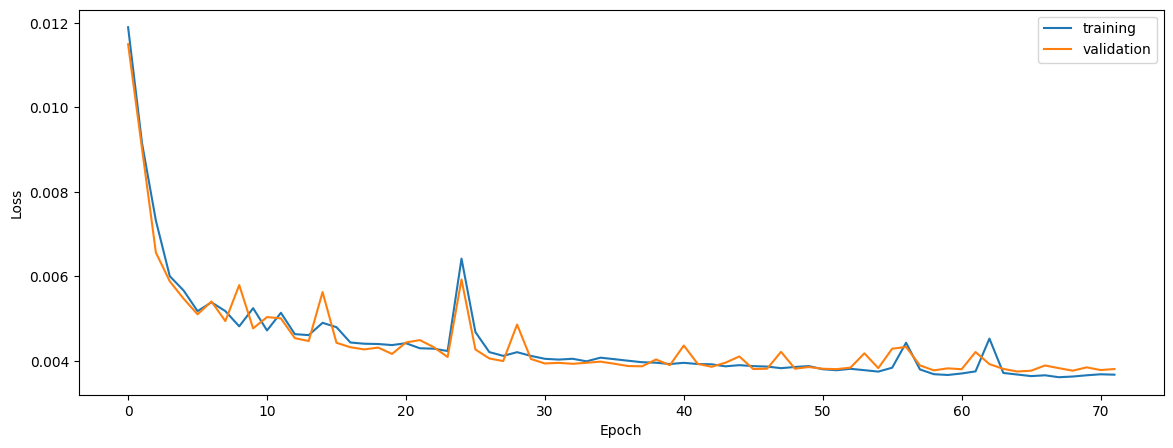

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8122060577068108
0.8271675548377511
0.7993985666755302


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.8122060577068108
0.8271675548377511
0.7993985666755302


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8043093028044714
0.820509673608433
0.7947099848222194


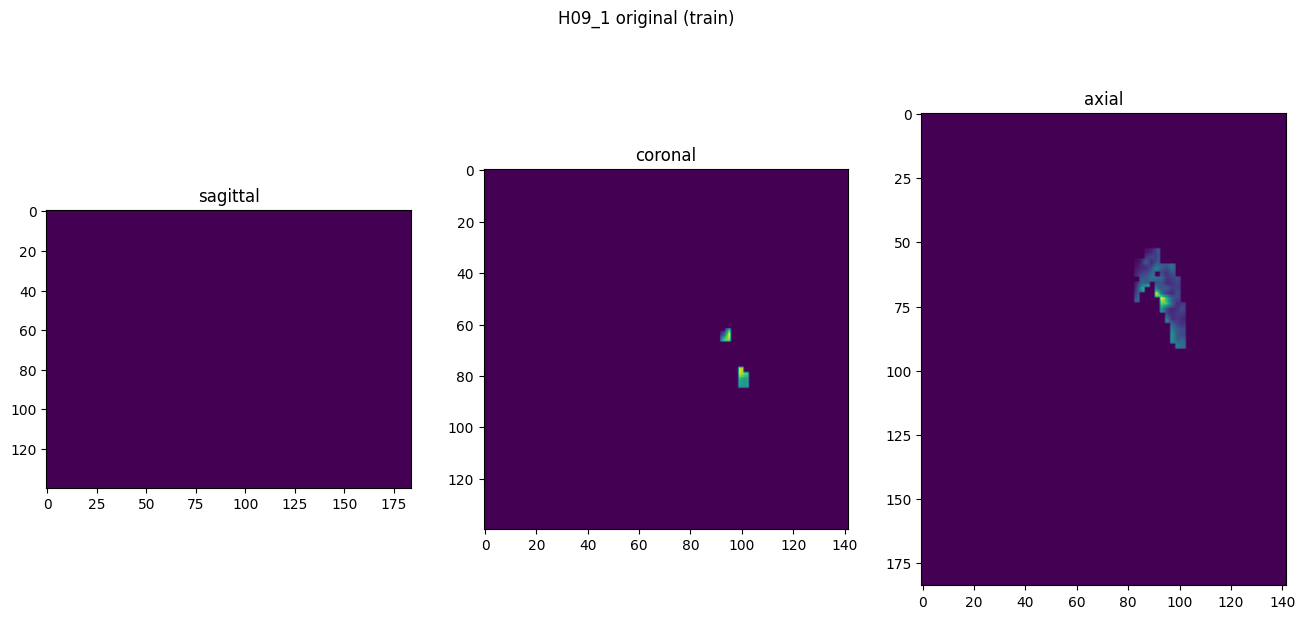

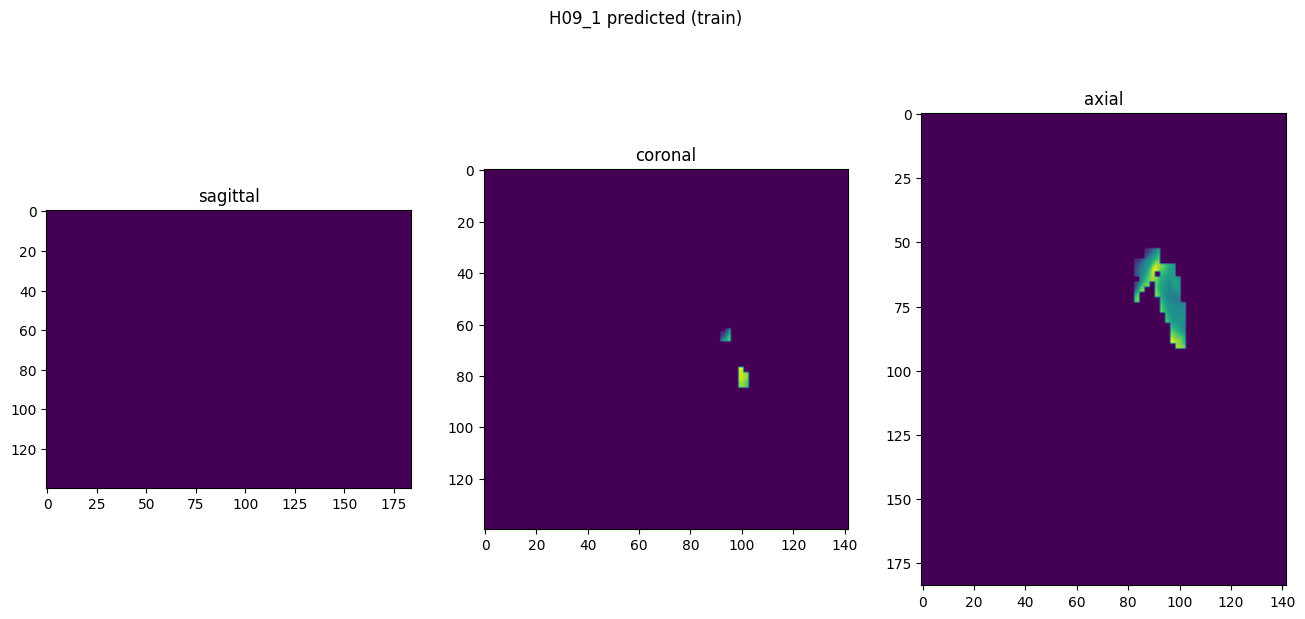

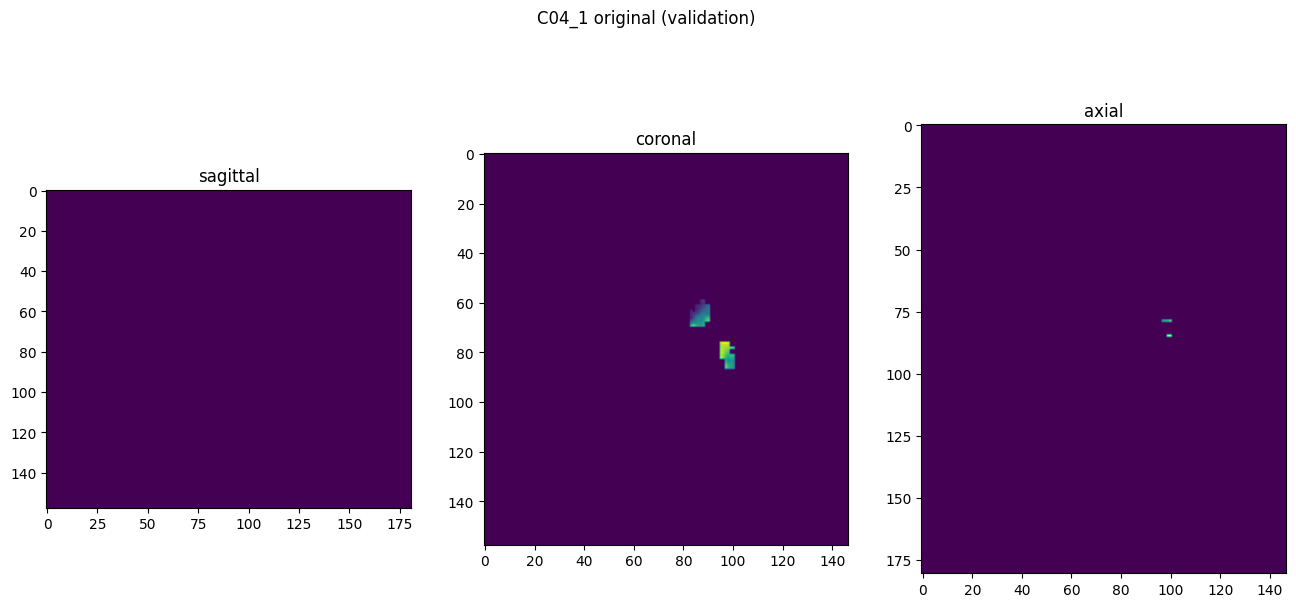

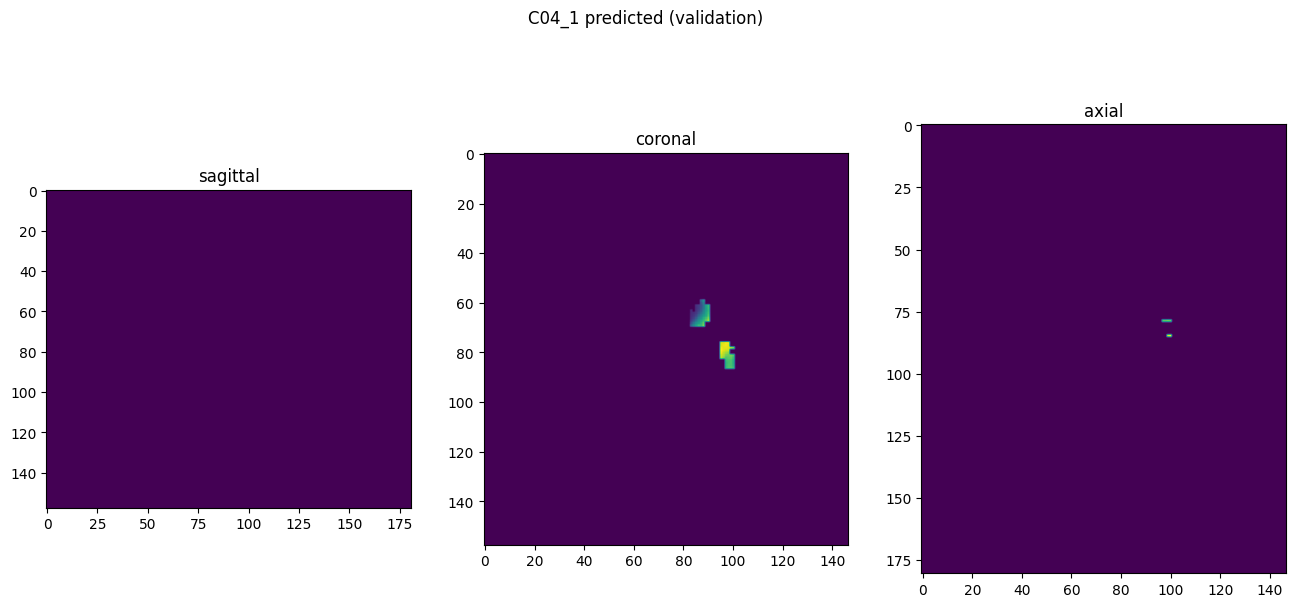

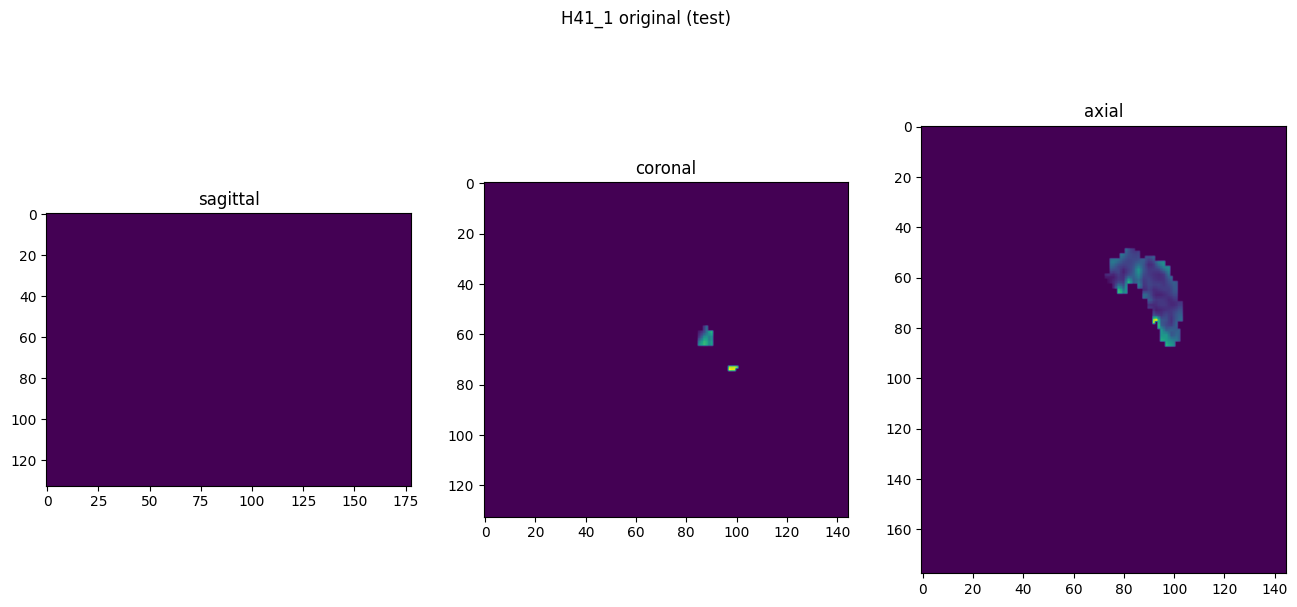

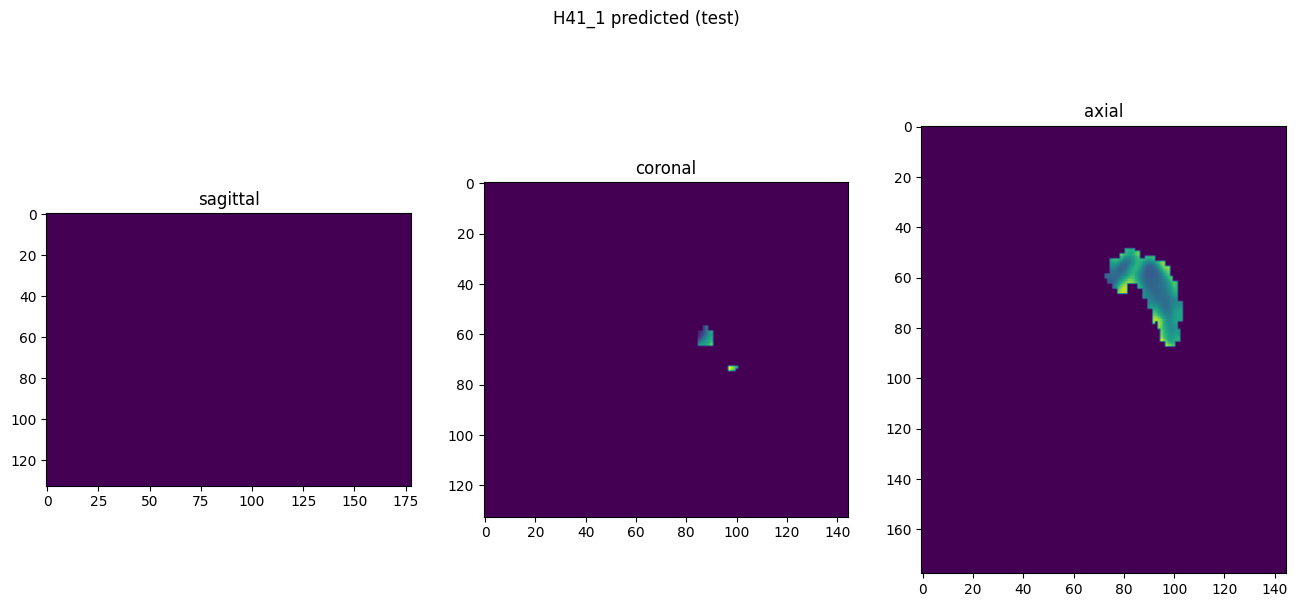

In [10]:
showResults(model, gen, threshold=None, background=False)